In [43]:
import pandas as pd
import numpy as np
import os 
import sys
import gget
import time
from collections import Counter
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
gf = pd.read_csv("/scratch/indikar_root/indikar1/cstansbu/ihep/references/geneNames.csv")
print(f"raw: {gf.shape=}")

gf = gf[gf['Feature'] == 'gene']
gf = gf[gf['gene_biotype'] == 'protein_coding']

gf = gf[['gene_name', 'gene_id', 'Chromosome', 'Start', 'End',]].drop_duplicates()
gf['gene_length'] = gf['End'] - gf['Start']

print(f"filtered: {gf.shape=}")

gf.head()

/home/cstansbu/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


raw: gf.shape=(3371244, 26)
filtered: gf.shape=(20023, 6)


,gene_name,gene_id,Chromosome,Start,End,gene_length
0,ATAD3B,ENSG00000160072,1,1471764,1497848,26084
129,PRDM16,ENSG00000142611,1,3069167,3438621,369454
358,SKI,ENSG00000157933,1,2228318,2310213,81895
395,PEX14,ENSG00000142655,1,10472287,10630758,158471
563,PLCH2,ENSG00000149527,1,2425979,2505532,79553


# Read Summary

,Total,Mapped,Forward,Reverse,file,percent_mapped,percent_forward,percent_reverse
1,8194865,7786080,4283252,3911613,LV1,0.950117,0.522675,0.477325
2,2549553,2431611,1325230,1224323,LV2,0.953740,0.519789,0.480211
3,6241955,6046045,3208556,3033399,LV3,0.968614,0.514031,0.485969
0,5141322,4995866,2630707,2510615,LV4,0.971708,0.511679,0.488321
4,7687424,7500199,3926825,3760599,negfib,0.975645,0.510812,0.489188


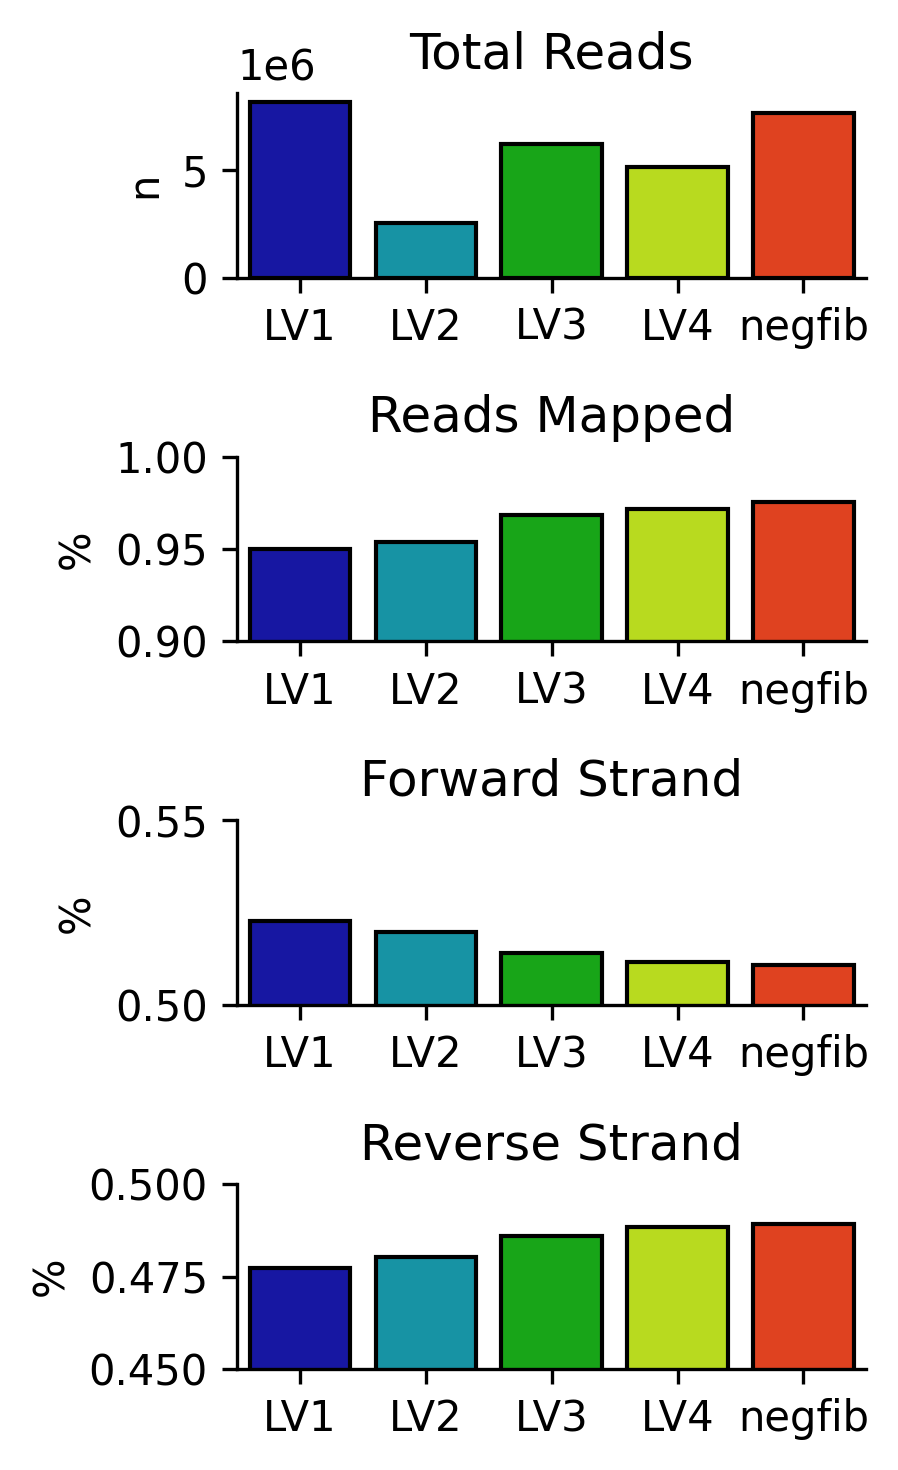

In [3]:
data_dir = "/scratch/indikar_root/indikar1/cstansbu/ihep/stats/"

def parse_bamstats(fpath):
    res = {}
    for i, line in enumerate(open(fpath)):
        if i in [5, 6, 7, 8]:
            clean_line  = line.split("(")[0].strip()
            field, num = clean_line.split(":")
            field = field.split(" ")[0].strip()
            num = int(num.strip())
            res[field] = num
    return res
            
    

df = []

for f in os.listdir(data_dir):
    fpath = f"{data_dir}{f}"
    file_id = f.split("_")[1].replace(".bamstats", "")

    row = parse_bamstats(fpath)
    row['file'] = file_id
    df.append(row)


df = pd.DataFrame(df)

df['percent_mapped'] = df['Mapped'] / df['Total']
df['percent_forward'] = df['Forward'] / df['Total']
df['percent_reverse'] = df['Reverse'] / df['Total']

df = df.sort_values(by='file')

plt.rcParams['figure.figsize'] = 3, 5
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(4, 1)

sns.barplot(data=df, 
            x='file',
            y='Total',
            palette='nipy_spectral',
            ec='k',
            ax=axs[0])

axs[0].set_title("Total Reads")
axs[0].set_ylabel("n")
axs[0].set_xlabel("")


sns.barplot(data=df, 
            x='file',
            y='percent_mapped',
            palette='nipy_spectral',
            ec='k',
            ax=axs[1])

axs[1].set_title("Reads Mapped")
axs[1].set_ylabel("%")
axs[1].set_xlabel("")
axs[1].set_ylim([0.9, 1])

sns.barplot(data=df, 
            x='file',
            y='percent_forward',
            palette='nipy_spectral',
            ec='k',
            ax=axs[2])

axs[2].set_title("Forward Strand")
axs[2].set_ylabel("%")
axs[2].set_xlabel("")
axs[2].set_ylim([0.5, 0.55])


sns.barplot(data=df, 
            x='file',
            y='percent_reverse',
            palette='nipy_spectral',
            ec='k',
            ax=axs[3])

axs[3].set_title("Reverse Strand")
axs[3].set_ylabel("%")
axs[3].set_xlabel("")
axs[3].set_ylim([0.45, 0.5])

plt.tight_layout()
sns.despine()

df.head()
    

# Investigate Expression

In [4]:
data_dir = "/scratch/indikar_root/indikar1/cstansbu/ihep/counts/"
scale_by = 1e6
p = 1000 # kilobase pair resolution on gene length

df = []

for f in os.listdir(data_dir):
    if f.endswith(".txt"):
        file_id = f.split("_")[1].replace(".counts.txt", "")
        fpath = f"{data_dir}{f}"
        
        tmp = pd.read_csv(fpath, sep='\t', header=None)
        tmp.columns = ['gene_id', 'read_count']

        tmp = pd.merge(tmp, gf, 
                       how='left', 
                       left_on='gene_id',
                       right_on='gene_id')

        print(f"{tmp.shape=}")

        # filter missing mappings
        tmp = tmp[tmp['gene_name'].notna()].reset_index(drop=True)

        # normalize expression
        tmp['reads_per_gene'] = tmp['read_count'] / (tmp['gene_length'] / p)
        tmp['TPM'] = scale_by * (tmp['reads_per_gene'] / tmp['read_count'].sum())
        tmp['file'] = file_id

        df.append(tmp)
                
df = pd.concat(df)
df['control'] = np.where(df['file'] == 'negfib', 'Control', 'TF')
df['logTPM'] = np.log1p(df['TPM'])

print(f"{df.shape=}")
df.head()

tmp.shape=(61865, 7)
tmp.shape=(61865, 7)
tmp.shape=(61865, 7)
tmp.shape=(61865, 7)
tmp.shape=(61865, 7)
df.shape=(97005, 12)


,gene_id,read_count,gene_name,Chromosome,Start,End,gene_length,reads_per_gene,TPM,file,control,logTPM
0,ENSG00000000003,26,TSPAN6,X,100627107.0,100639991.0,12884.0,2.018007,1.655995,LV1,TF,0.976819
1,ENSG00000000005,0,TNMD,X,100584935.0,100599885.0,14950.0,0.000000,0.000000,LV1,TF,0.000000
2,ENSG00000000419,134,DPM1,20,50934866.0,50959140.0,24274.0,5.520310,4.530016,LV1,TF,1.710191
3,ENSG00000000457,30,SCYL3,1,169849630.0,169894267.0,44637.0,0.672088,0.551522,LV1,TF,0.439236
4,ENSG00000000460,24,C1orf112,1,169662006.0,169854080.0,192074.0,0.124952,0.102537,LV1,TF,0.097614


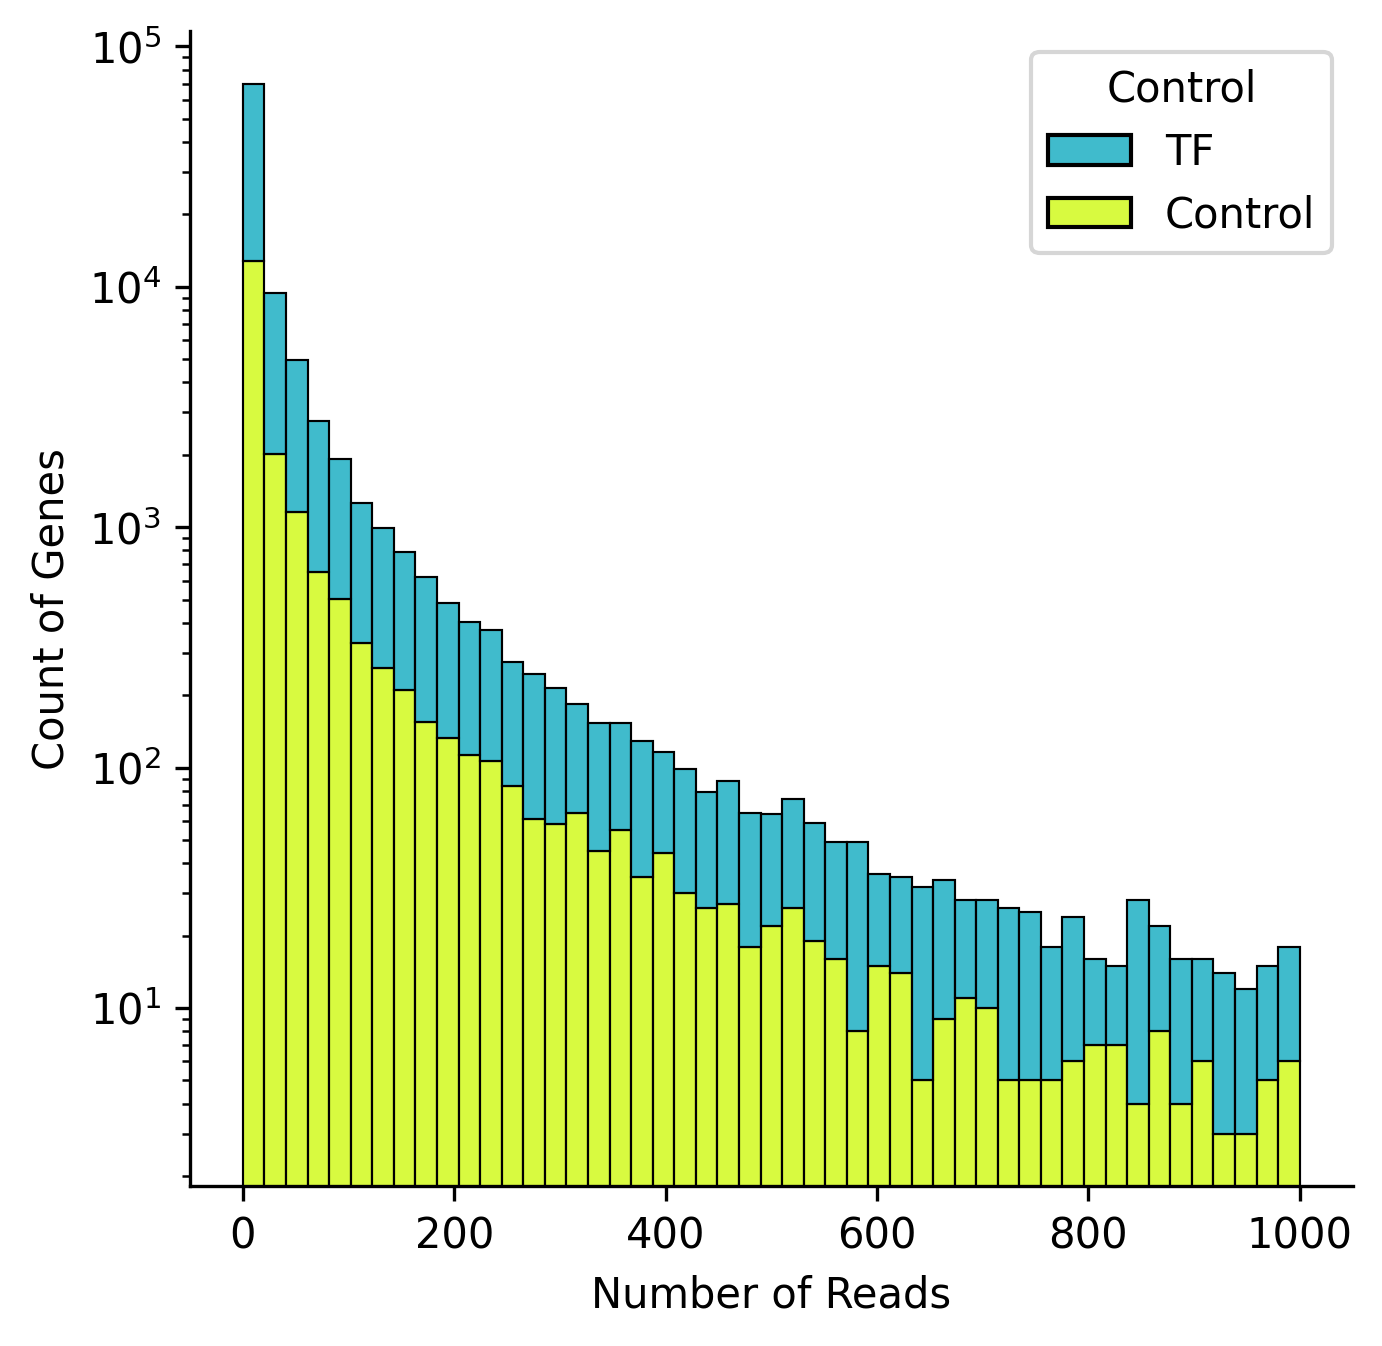

In [5]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.dpi'] = 300

sns.histplot(data=pdf,
             x='read_count', 
             hue='control',
             multiple='stack',
             palette='nipy_spectral',
             bins=np.linspace(0, 1000))

plt.yscale('log')
plt.ylabel("Count of Genes")
plt.xlabel("Number of Reads")

sns.move_legend(plt.gca(),
                title='Control', 
                loc='upper right')

sns.despine()

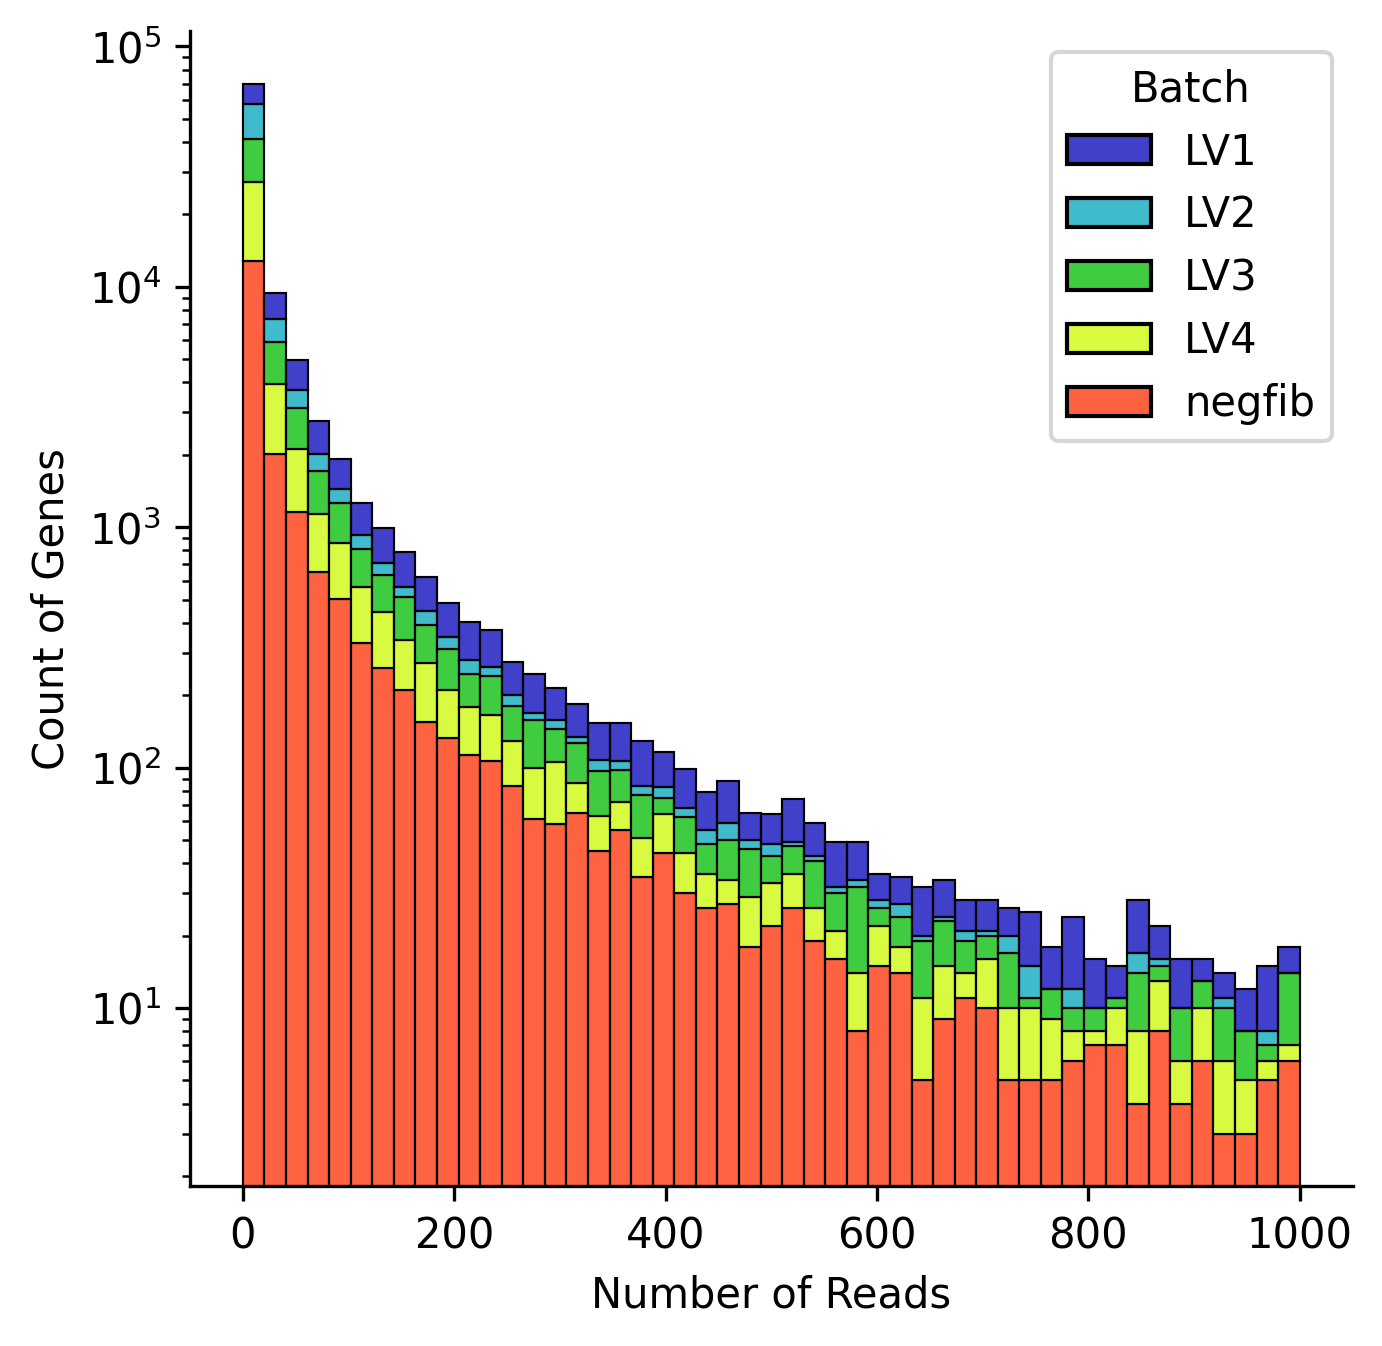

In [6]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.dpi'] = 300

sns.histplot(data=pdf,
             x='read_count', 
             hue='file',
             multiple='stack',
             palette='nipy_spectral',
             bins=np.linspace(0, 1000))

plt.yscale('log')
plt.ylabel("Count of Genes")
plt.xlabel("Number of Reads")

sns.move_legend(plt.gca(),
                title='Batch', 
                loc='upper right')

sns.despine()

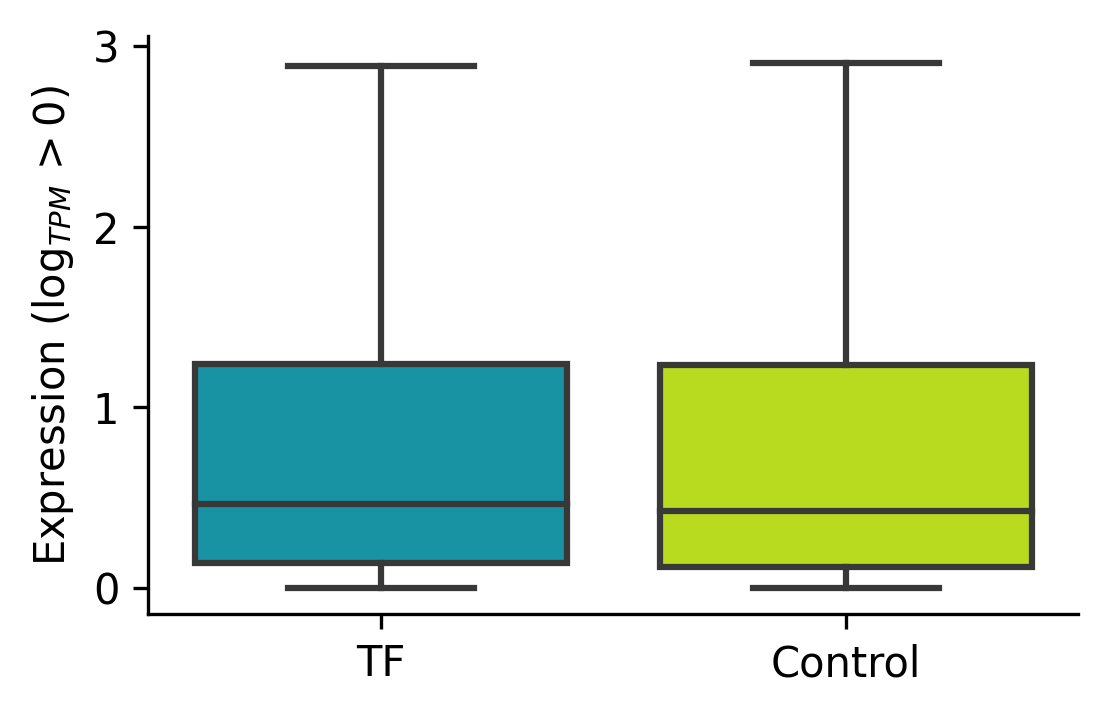

In [7]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['logTPM'] > 0].reset_index(drop=True)


plt.rcParams['figure.figsize'] = 4, 2.5
plt.rcParams['figure.dpi'] = 300

sns.boxplot(data=pdf, 
            x='control',
            y='logTPM',
            hue='control',
            palette='nipy_spectral',
            dodge=False,
            showfliers=False,)

plt.ylabel(r"Expression ($\log_{TPM} > 0$)")
plt.xlabel("")
plt.gca().legend().remove()

sns.despine()

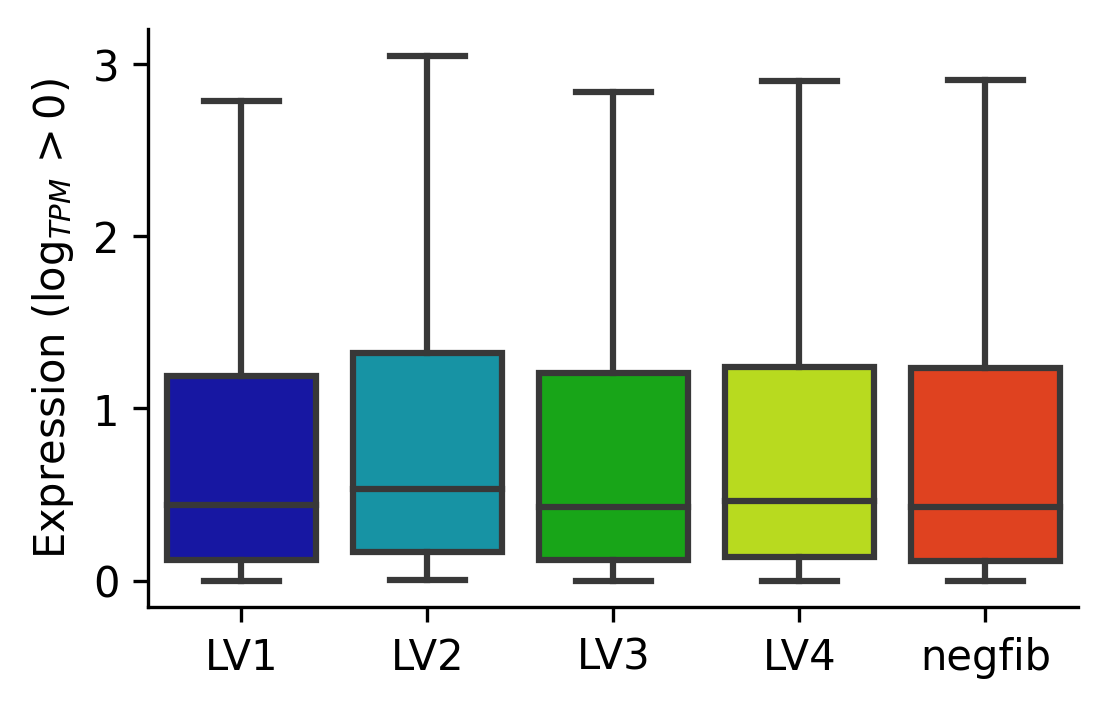

In [8]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['logTPM'] > 0].reset_index(drop=True)


plt.rcParams['figure.figsize'] = 4, 2.5
plt.rcParams['figure.dpi'] = 300

sns.boxplot(data=pdf, 
            x='file',
            y='logTPM',
            hue='file',
            palette='nipy_spectral',
            dodge=False,
            showfliers=False,)

plt.ylabel(r"Expression ($\log_{TPM} > 0$)")
plt.xlabel("")
plt.gca().legend().remove()

sns.despine()

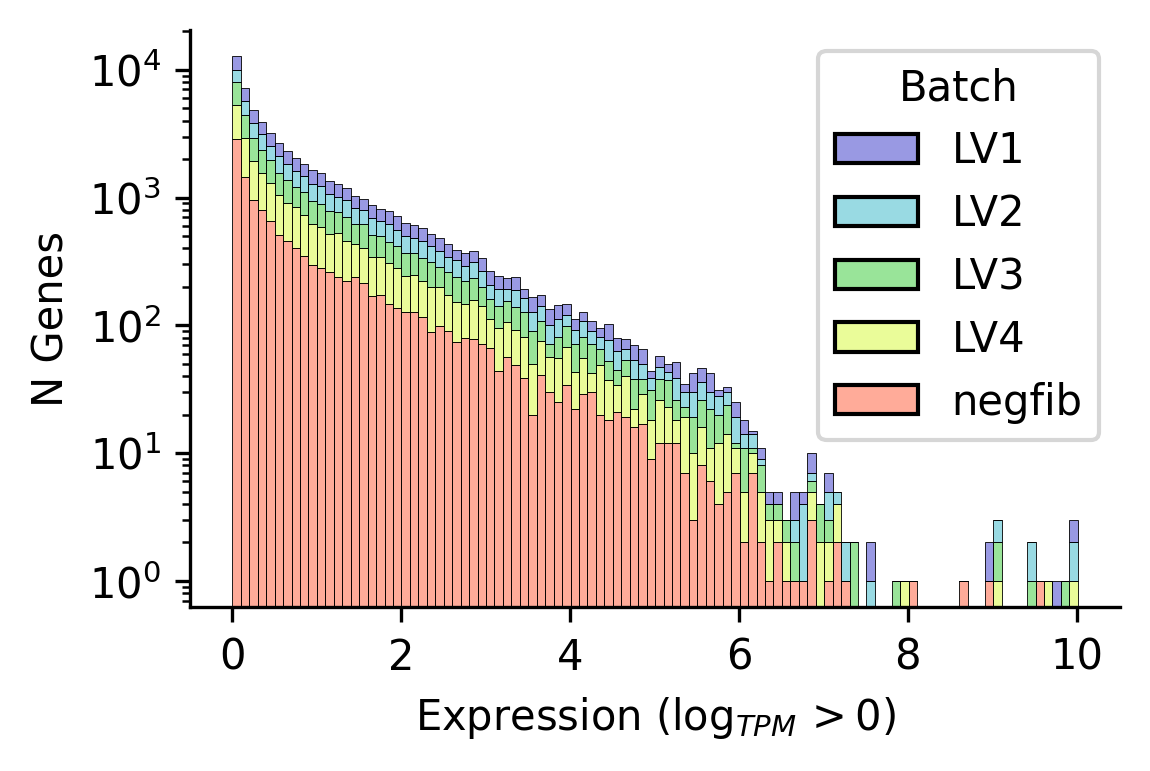

In [9]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['logTPM'] > 0].reset_index(drop=True)


plt.rcParams['figure.figsize'] = 4, 2.5
plt.rcParams['figure.dpi'] = 300

sns.histplot(data=pdf, 
            x='logTPM',
            hue='file',
            bins=100,
            alpha=0.4,
            multiple='stack',
            palette='nipy_spectral',)

sns.move_legend(plt.gca(),
                title='Batch', 
                loc='upper right')

plt.xlabel(r"Expression ($\log_{TPM} > 0$)")
plt.ylabel("N Genes")
plt.yscale("log")
sns.despine()

In [10]:
# break

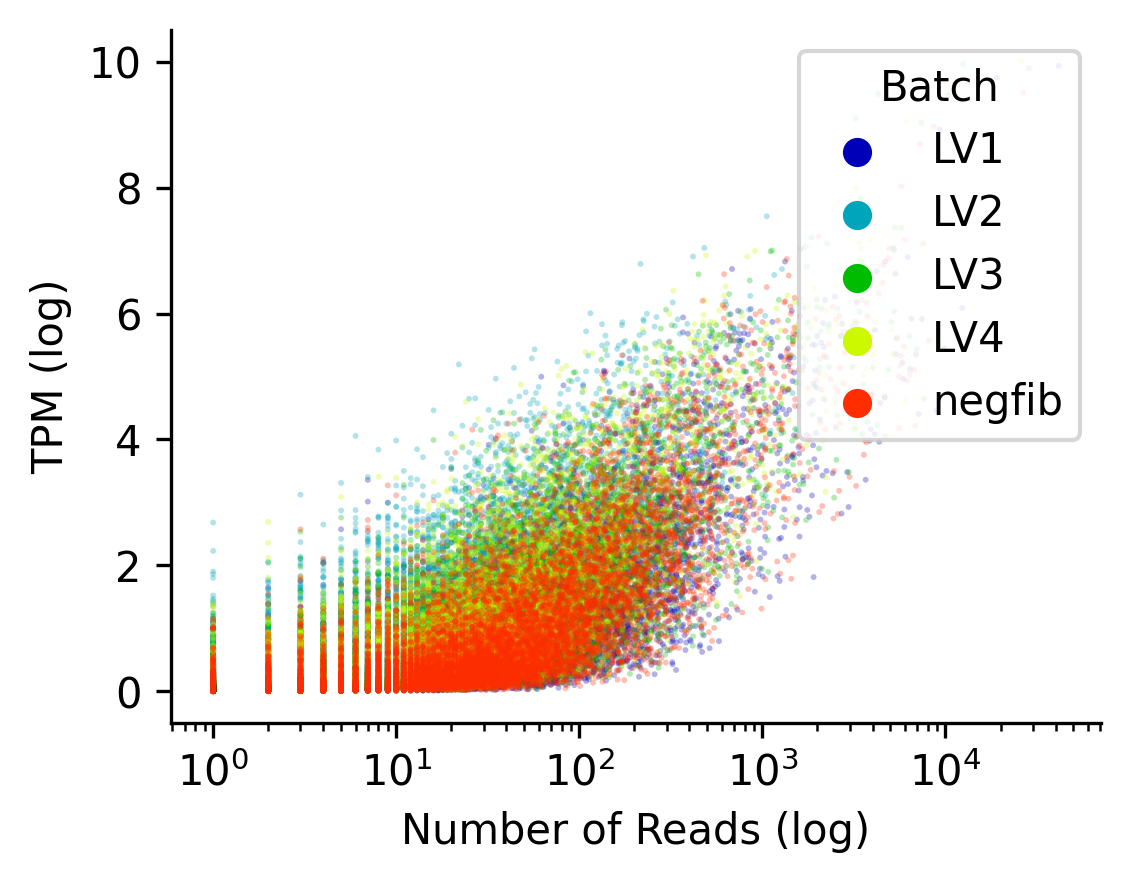

In [11]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['logTPM'] > 0].reset_index(drop=True)

plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['figure.dpi'] = 300

sns.scatterplot(data=pdf,
                x='read_count',
                y='logTPM', 
                hue='file',
                palette='nipy_spectral',
                s=2, 
                alpha=0.3,
                ec='none')


plt.xscale('log')
plt.ylabel("TPM (log)")
plt.xlabel("Number of Reads (log)")

sns.move_legend(plt.gca(),
                title='Batch', 
                loc='upper right')

sns.despine()

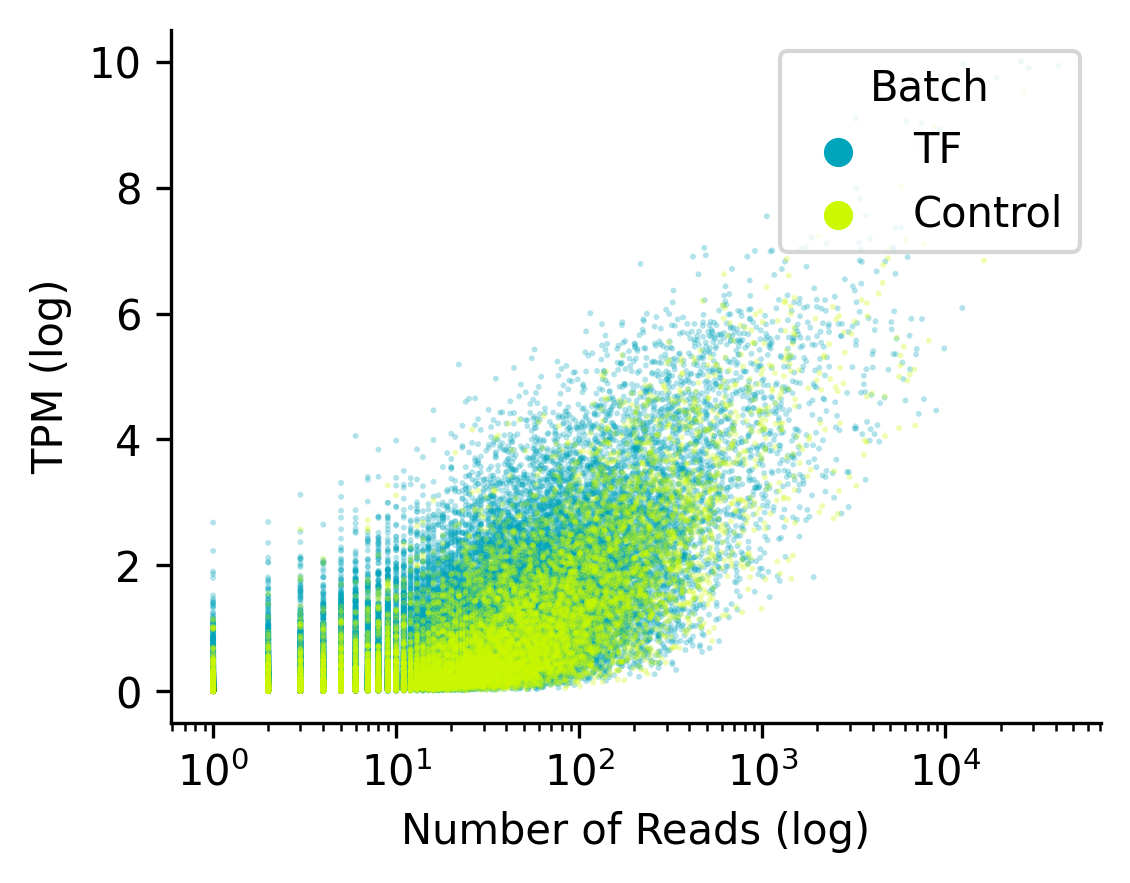

In [12]:
pdf = df.copy()
pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['logTPM'] > 0].reset_index(drop=True)

plt.rcParams['figure.figsize'] = 4, 3
plt.rcParams['figure.dpi'] = 300

sns.scatterplot(data=pdf,
                x='read_count',
                y='logTPM', 
                hue='control',
                palette='nipy_spectral',
                s=2, 
                alpha=0.3,
                ec='none')


plt.xscale('log')
plt.ylabel("TPM (log)")
plt.xlabel("Number of Reads (log)")

sns.move_legend(plt.gca(),
                title='Batch', 
                loc='upper right')

sns.despine()

# Highest Expression

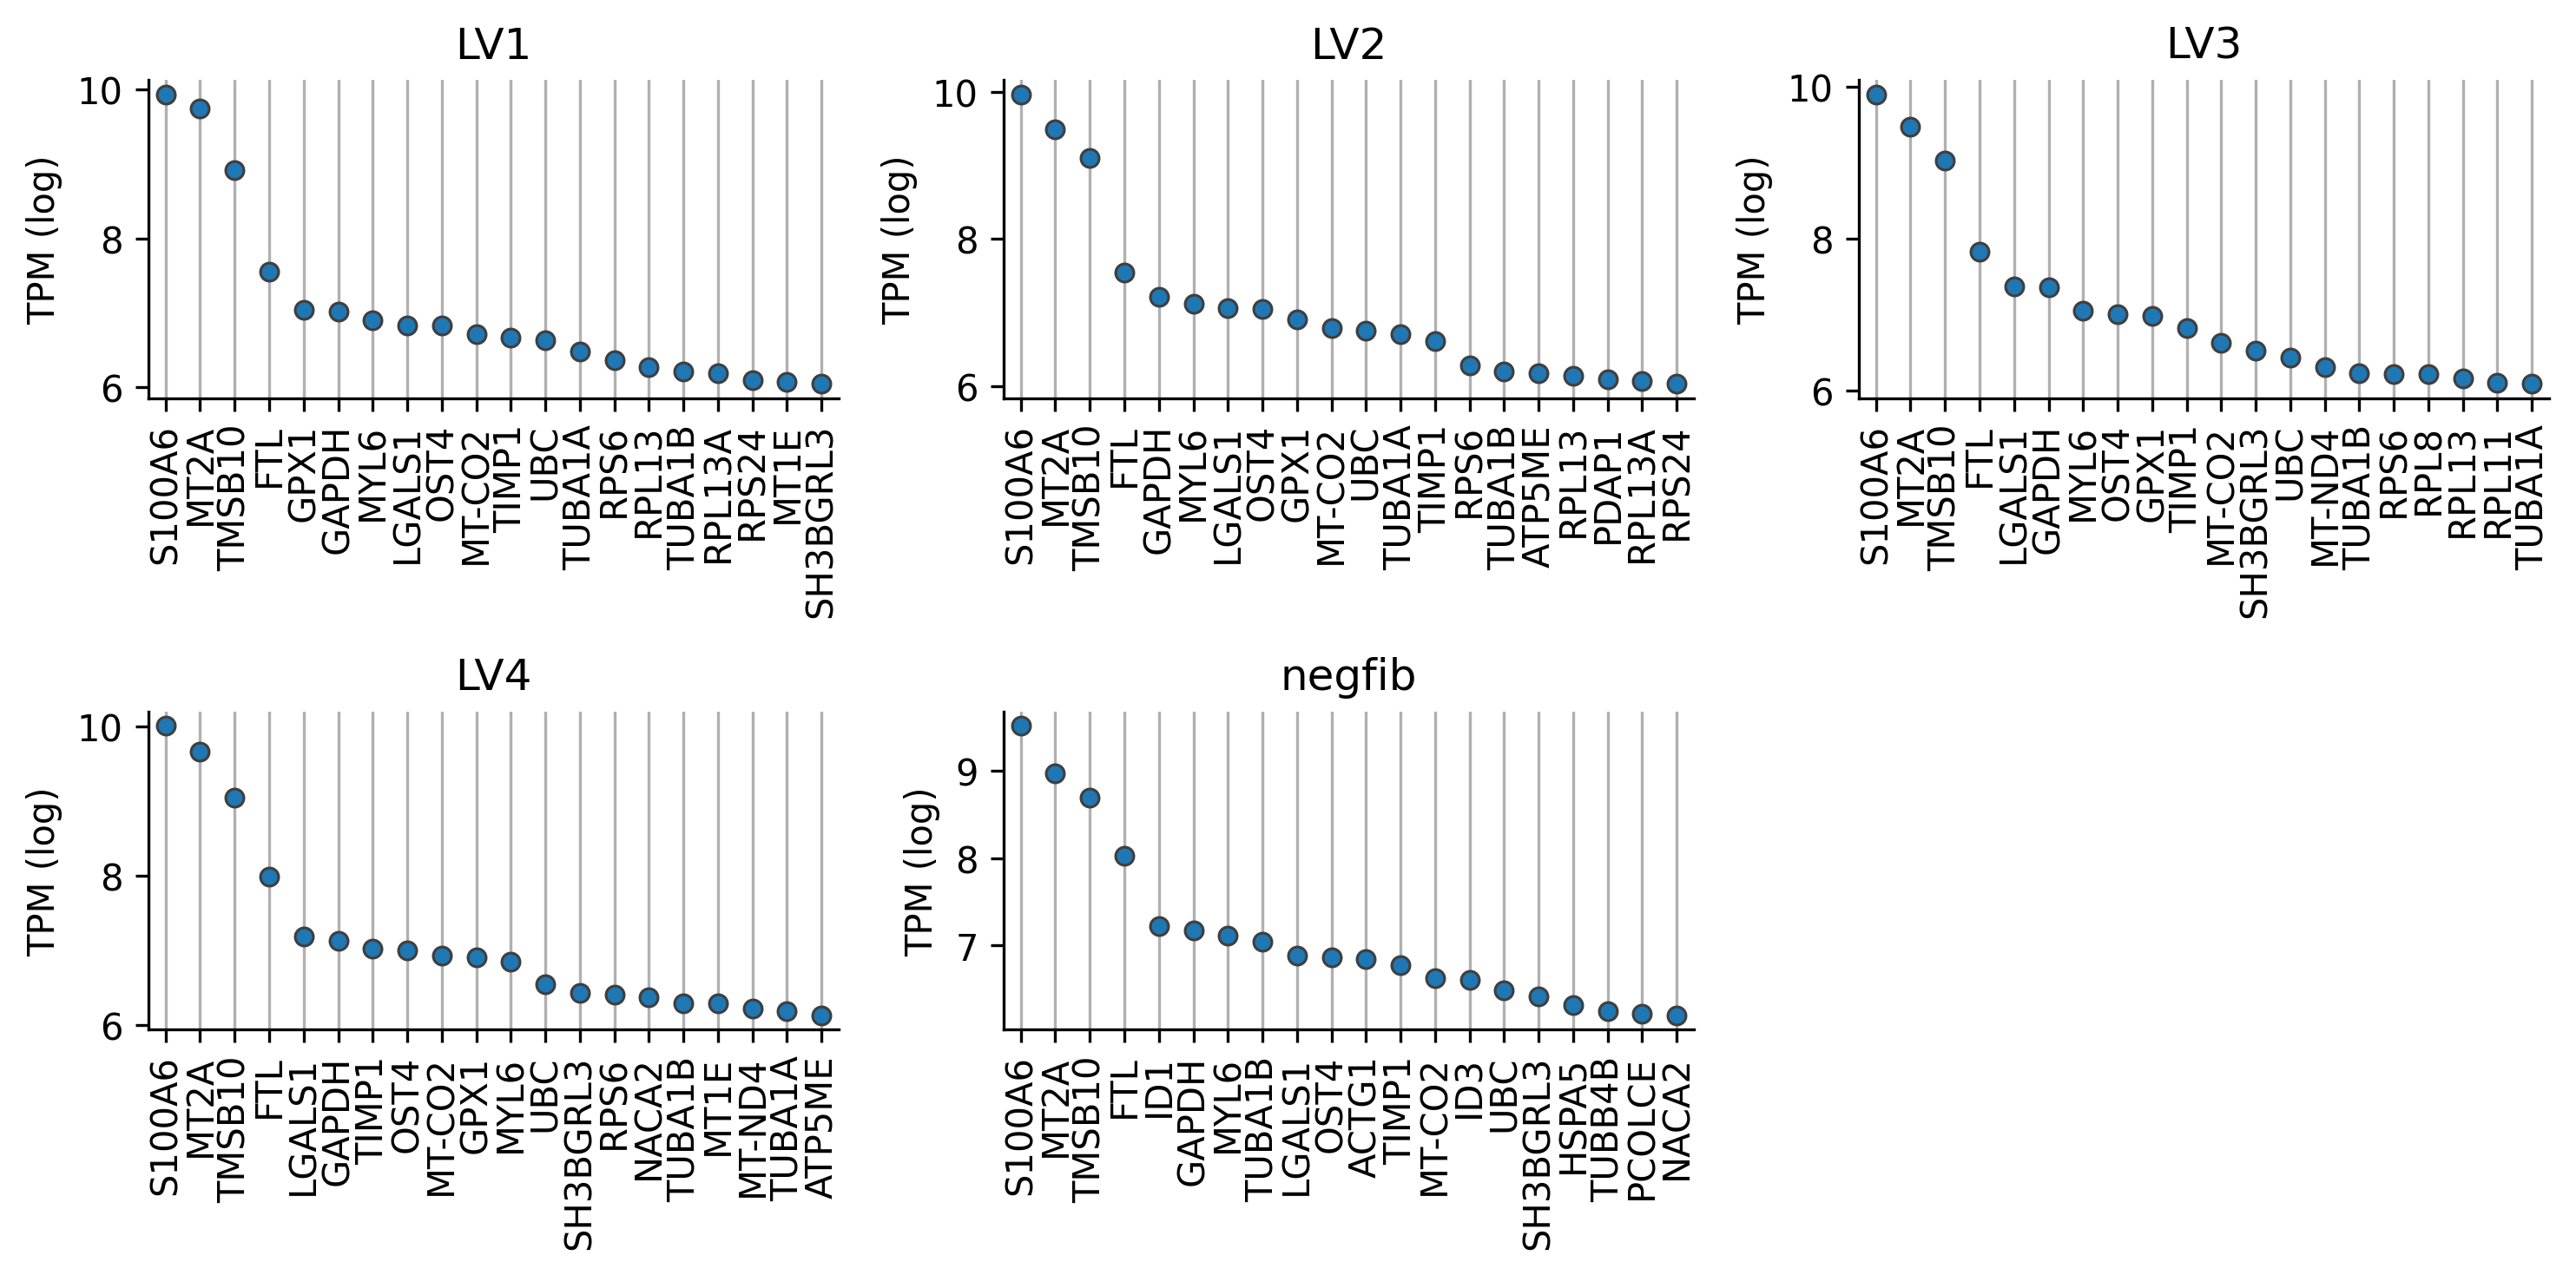

In [13]:
n = 20

pdf = df.copy()
pdf = pdf.sort_values(by='file')

plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(2, 3)
axs = axs.ravel()

for i, (file, group) in enumerate(pdf.groupby('file')):

    group = group.sort_values(by='logTPM', ascending=False)
    group = group.head(n)

    sns.stripplot(data=group,
                    x='gene_name',
                    y='logTPM',
                    s=5,
                    linewidth=0.75,
                    ec='k',
                    zorder=3,
                    ax=axs[i])

    axs[i].xaxis.grid(True)
    axs[i].set_title(f"{file}")
    axs[i].set_ylabel("TPM (log)")
    axs[i].set_xlabel("")
    axs[i].tick_params(axis='x', rotation=90)


fig.delaxes(axs[5])
plt.tight_layout()
sns.despine()

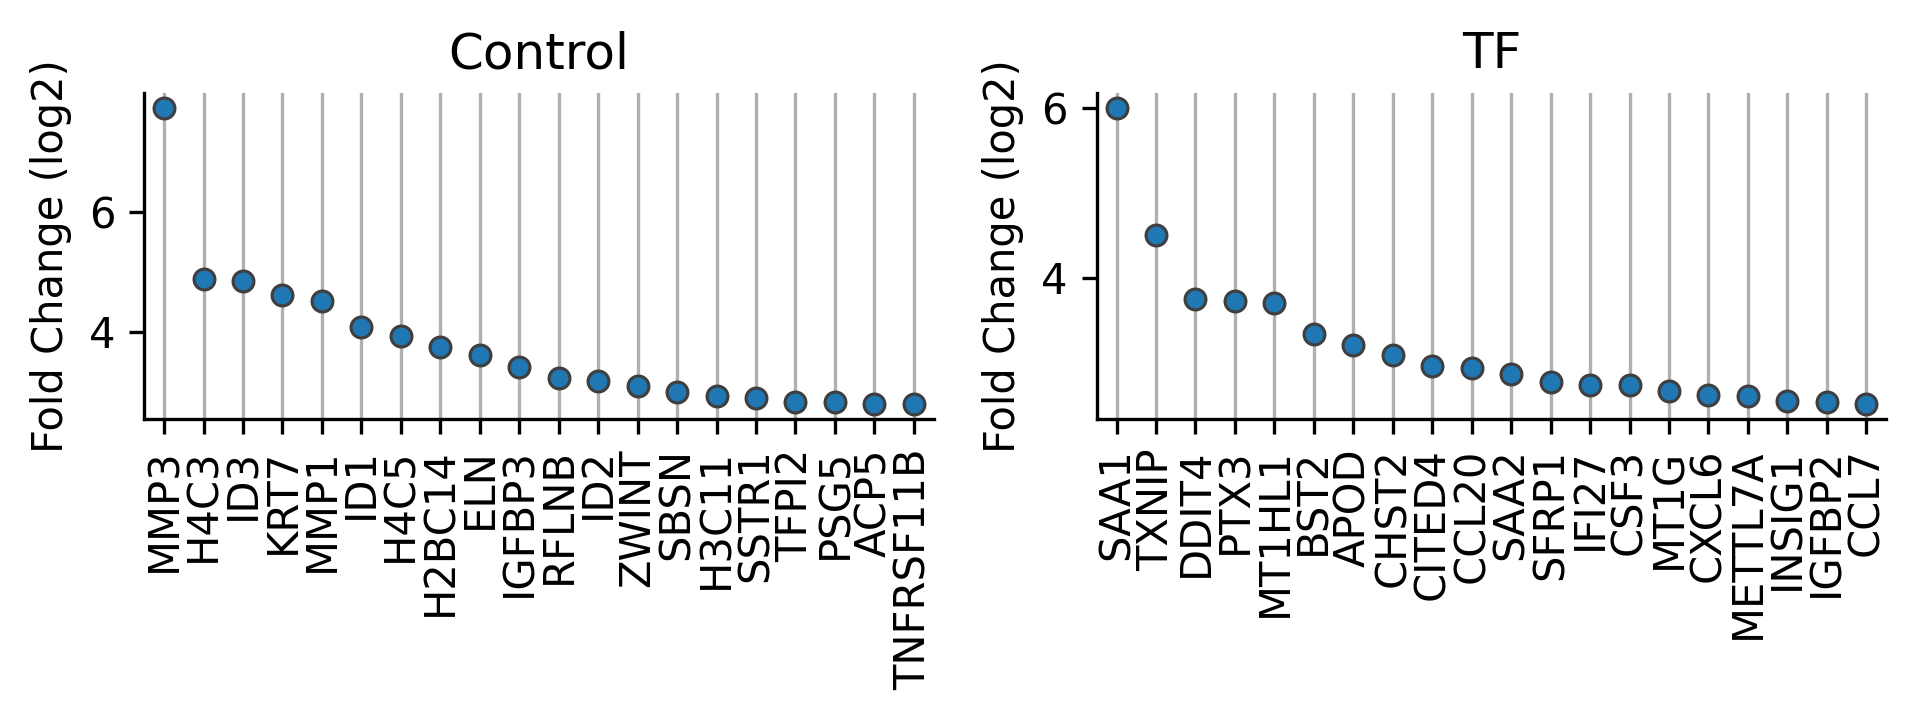

In [14]:
# plot highest expressed gene by fold change
n = 20

pdf = df.copy()
pdf = pdf.sort_values(by='file')

pdf = pd.pivot_table(pdf, index='gene_name',
                     columns='control',
                     values='TPM')


plt.rcParams['figure.figsize'] = 6.5, 2.5
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

for i, file in enumerate(pdf.columns):

    target = pdf[file]
    comp = pdf.loc[:, pdf.columns != file].mean(axis=1)

    # compute and sort
    foldchanges = (target + 1) / (comp + 1)
    logfoldchanges = np.log2(foldchanges)
    logfoldchanges = logfoldchanges.sort_values(ascending=False)
    logfoldchanges = logfoldchanges.head(n).reset_index(drop=False)

    # print(logfoldchanges)

    sns.stripplot(data=logfoldchanges,
                    x='gene_name',
                    y=0,
                    s=5,
                    linewidth=0.75,
                    ec='k',
                    zorder=3,
                    ax=axs[i])

    axs[i].xaxis.grid(True)
    axs[i].set_title(f"{file}")
    axs[i].set_ylabel("Fold Change (log2)")
    axs[i].set_xlabel("")
    axs[i].tick_params(axis='x', rotation=90)


plt.tight_layout()
sns.despine()
    
    
    




In [24]:
# print the defining characteristics of each sample through GSEA

n = 500

pdf = df.copy()
pdf = pdf.sort_values(by='file')

pdf = pd.pivot_table(pdf, index='gene_name',
                     columns='control',
                     values='TPM')

for i, file in enumerate(pdf.columns):

    target = pdf[file]
    comp = pdf.loc[:, pdf.columns != file].mean(axis=1)

    # compute and sort
    foldchanges = (target + 1) / (comp + 1)
    logfoldchanges = np.log2(foldchanges)
    logfoldchanges = logfoldchanges.sort_values(ascending=False)
    logfoldchanges = logfoldchanges.head(n)

    # get genes to query
    query_genes = list(logfoldchanges.index)

    print(f"====== {file} ======")
    edf = gget.enrichr(query_genes, database='ontology')

    for idx, row in edf.head(10).iterrows():
        pname = row['path_name'].split("(")[0].strip()
        p = f"{row['adj_p_val']:.3f}"
        genes = ";".join(row['overlapping_genes'])
        print(f"\t{pname} ({p=}) {genes=}")


    print()

Thu Nov  9 11:49:42 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


====== Control ======


Thu Nov  9 11:49:43 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


	mitotic spindle organization (p='0.000') genes='ZWILCH;CDCA8;SKA1;AURKB;CDC20;CCNB1;DSN1;NUP85;STMN1;SPDL1;BUB1;PLK1;KIF23;DYNLL1;SMC1A;TUBG1;NDC80;ZWINT;TPX2;CENPF;KIF4B;KIFC1;BIRC5;CENPM;KIF2C;CENPN;RAN;SPC24;SPC25'
	mitotic sister chromatid segregation (p='0.000') genes='SPAG5;CDCA5;PLK1;CDCA8;NCAPG;KIF23;KIF22;HASPIN;SMC1A;TUBG1;SMC4;NDC80;ZWINT;SMC2;CCNB1;DSN1;CDC23;KIF18B;KIFC1;CDK1;KIF2C;SPDL1;CEP55;RAN'
	microtubule cytoskeleton organization involved in mitosis (p='0.000') genes='ZWILCH;CDCA8;SKA1;AURKB;CDC20;CCNB1;DSN1;NUP85;STMN1;SPDL1;BUB1;PLK1;DYNLL1;TUBG1;NDC80;ZWINT;CENPF;KIF4B;BIRC5;CENPM;KIF2C;CENPN;RAN;SPC24;SPC25'
	DNA replication initiation (p='0.000') genes='CDT1;MCM7;MCM8;GMNN;CDC6;CDC45;ORC6;ORC1;CDK2;POLE3;MCM3;MCM4;MCM5;MCM6;MCM2'
	DNA metabolic process (p='0.000') genes='TOP2A;DCLRE1B;FEN1;PCNA;MCM7;MCM8;GMNN;HMGB2;HMGB3;TYMS;RECQL4;ORC6;CDC45;ORC1;KPNA2;NUDT15;CDT1;XRCC5;PARP2;RFC2;CDC6;SMC1A;APEX1;UBE2T;CDK2;POLE3;CDK1;MCM3;MCM4;MCM5;MCM6;DCTPP1;RAN;MCM2'
	p

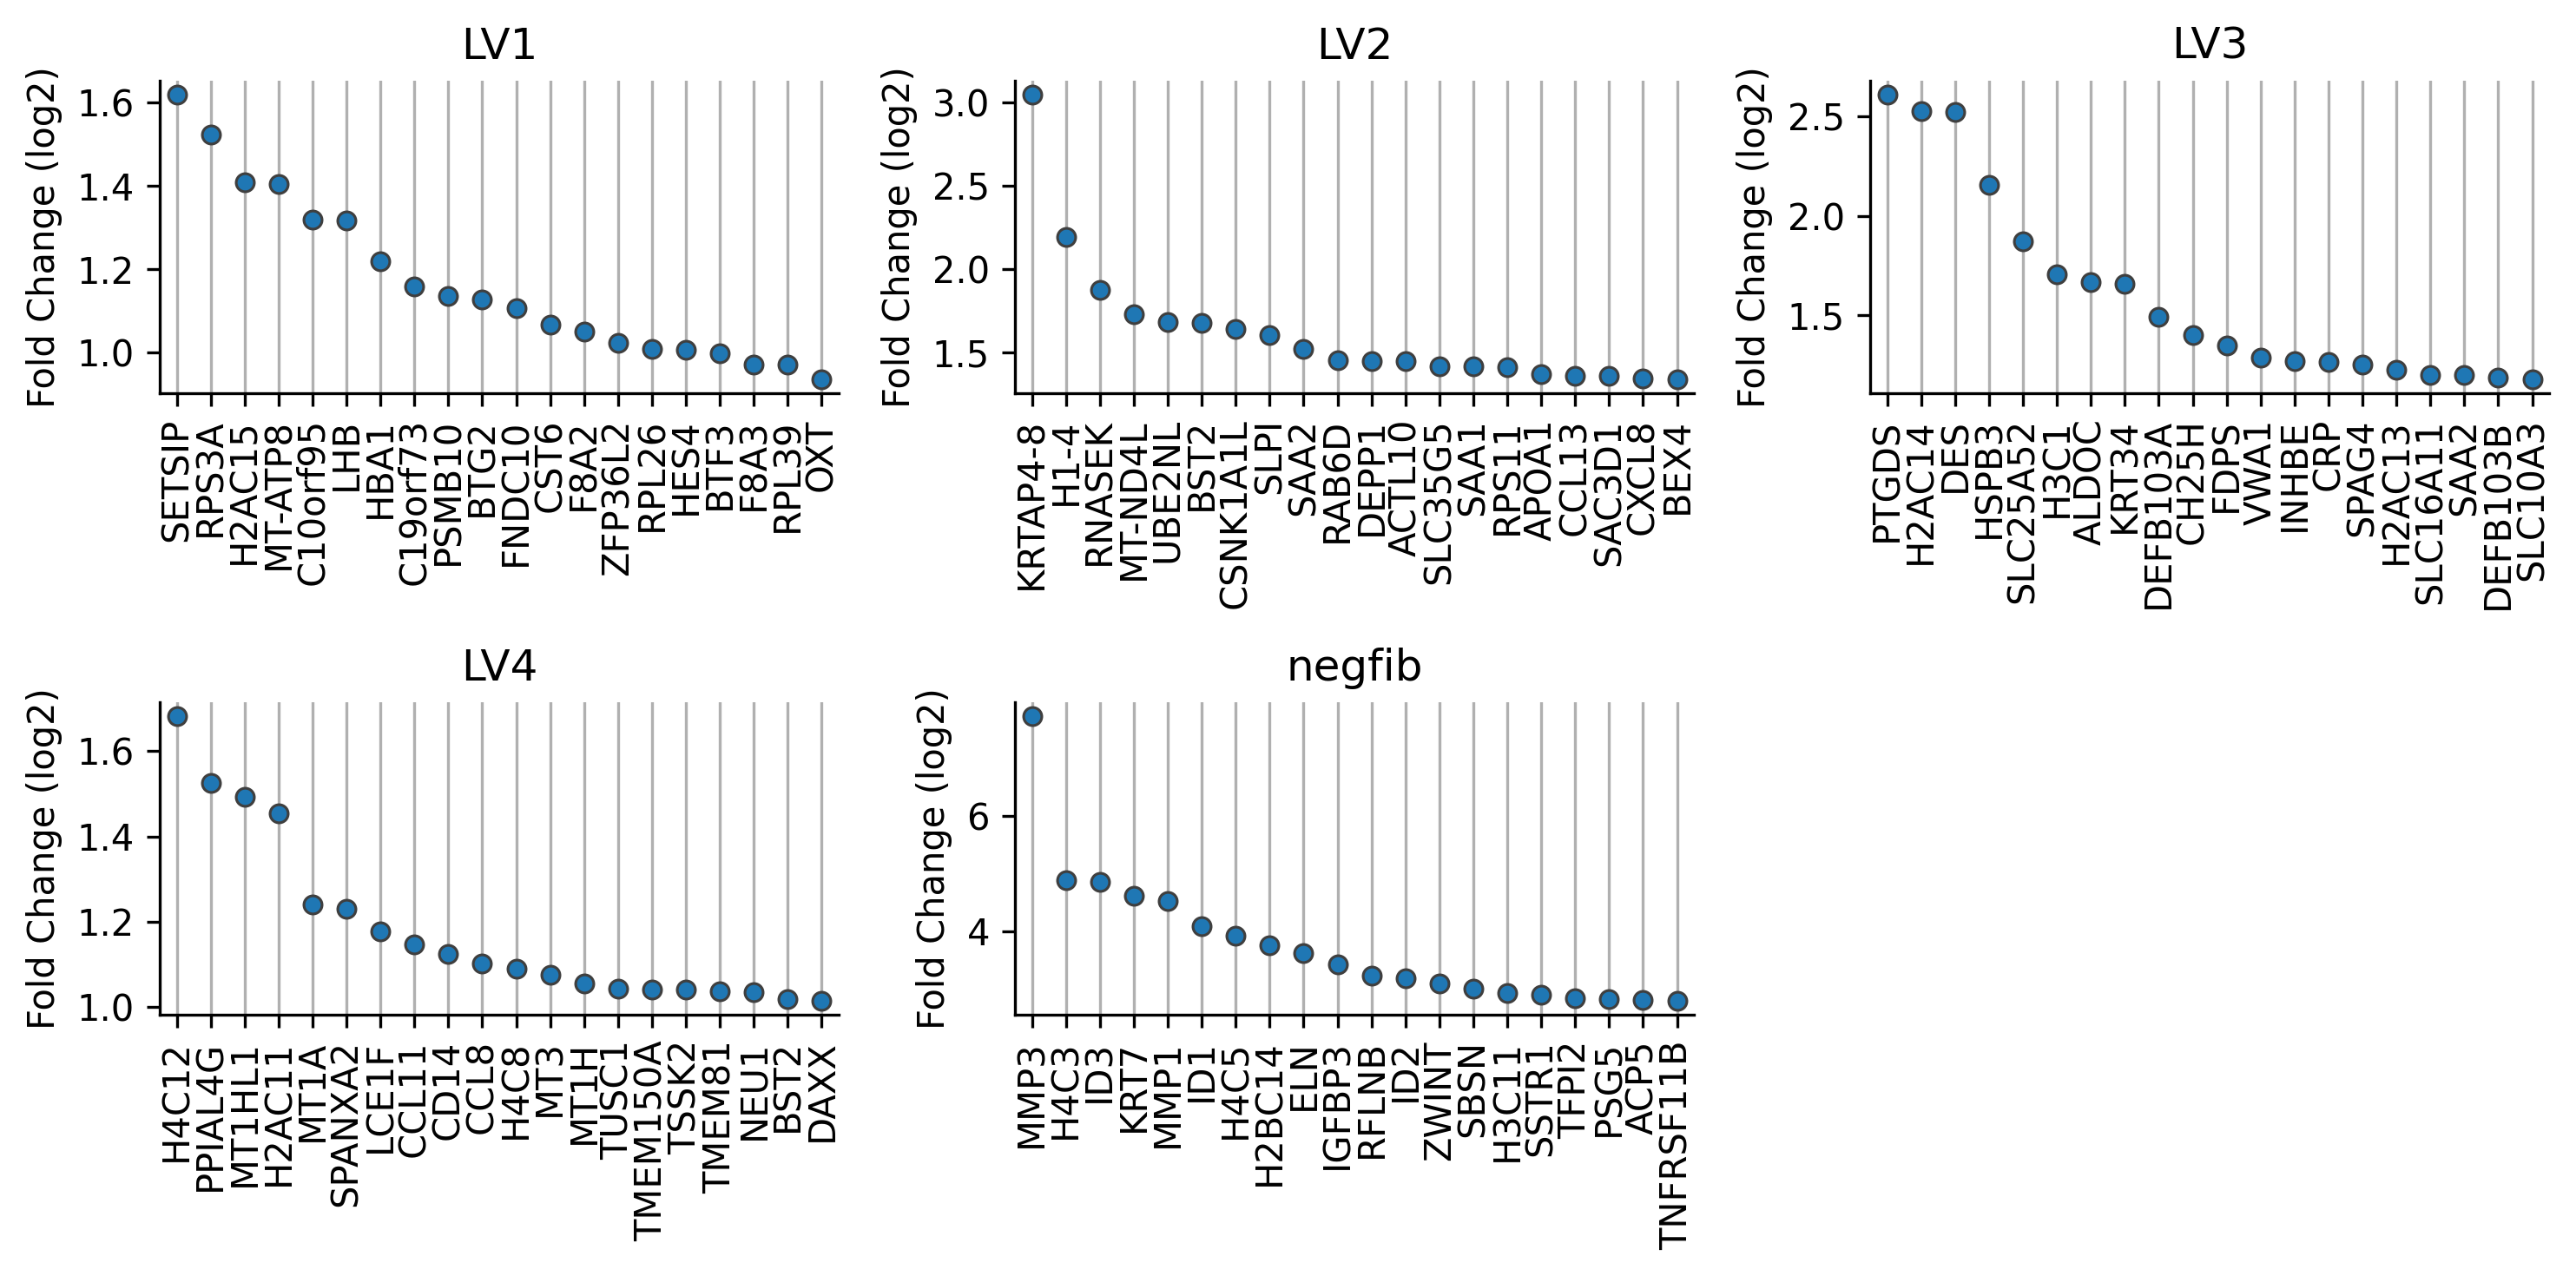

In [25]:
# plot highest expressed gene by fold change
n = 20

pdf = df.copy()
pdf = pdf.sort_values(by='file')

pdf = pd.pivot_table(pdf, index='gene_name',
                     columns='file',
                     values='TPM')


plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(2, 3)
axs = axs.ravel()

for i, file in enumerate(pdf.columns):

    target = pdf[file]
    comp = pdf.loc[:, pdf.columns != file].mean(axis=1)

    # compute and sort
    foldchanges = (target + 1) / (comp + 1)
    logfoldchanges = np.log2(foldchanges)
    logfoldchanges = logfoldchanges.sort_values(ascending=False)
    logfoldchanges = logfoldchanges.head(n).reset_index(drop=False)

    # print(logfoldchanges)

    sns.stripplot(data=logfoldchanges,
                    x='gene_name',
                    y=0,
                    s=5,
                    linewidth=0.75,
                    ec='k',
                    zorder=3,
                    ax=axs[i])

    axs[i].xaxis.grid(True)
    axs[i].set_title(f"{file}")
    axs[i].set_ylabel("Fold Change (log2)")
    axs[i].set_xlabel("")
    axs[i].tick_params(axis='x', rotation=90)


fig.delaxes(axs[5])
plt.tight_layout()
sns.despine()

In [26]:
# print the defining characteristics of each sample through GSEA

n = 100

pdf = df.copy()
pdf = pdf.sort_values(by='file')

pdf = pd.pivot_table(pdf, index='gene_name',
                     columns='file',
                     values='TPM')

for i, file in enumerate(pdf.columns):

    target = pdf[file]
    comp = pdf.loc[:, pdf.columns != file].mean(axis=1)

    # compute and sort
    foldchanges = (target + 1) / (comp + 1)
    logfoldchanges = np.log2(foldchanges)
    logfoldchanges = logfoldchanges.sort_values(ascending=False)
    logfoldchanges = logfoldchanges.head(n)

    # get genes to query
    query_genes = list(logfoldchanges.index)

    print(f"====== {file} ======")
    edf = gget.enrichr(query_genes, database='ontology')

    for idx, row in edf.head(10).iterrows():
        pname = row['path_name'].split("(")[0].strip()
        p = f"{row['adj_p_val']:.3f}"
        genes = ";".join(row['overlapping_genes'])
        print(f"\t{pname} ({p=}) {genes=}")
    
    time.sleep(1)


    print()

Thu Nov  9 11:50:07 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


====== LV1 ======
	nuclear-transcribed mRNA catabolic process, nonsense-mediated decay (p='0.000') genes='RPS15A;RPLP2;RPS3A;RPL26;RPL37;PABPC1;RPS27A;RPL39;RPS12'
	nuclear-transcribed mRNA catabolic process (p='0.000') genes='RPS15A;RPLP2;RPS3A;RPL26;RPL37;PABPC1;RPS27A;RPL39;ZFP36L1;RPS12'
	SRP-dependent cotranslational protein targeting to membrane (p='0.000') genes='RPS15A;RPLP2;RPS3A;RPL37;RPL26;RPS27A;RPL39;RPS12'
	cotranslational protein targeting to membrane (p='0.000') genes='RPS15A;RPLP2;RPS3A;RPL37;RPL26;RPS27A;RPL39;RPS12'
	protein targeting to ER (p='0.000') genes='RPS15A;RPLP2;RPS3A;RPL26;RPL37;RPS27A;RPL39;RPS12'
	cytoplasmic translation (p='0.000') genes='RPS15A;RPS3A;RPL37;RPL26;RPS27A;RPL39;RPS12'
	peptide biosynthetic process (p='0.000') genes='RPS15A;RPLP2;RPS3A;RPL26;RPL37;RPS27A;RPL39;RPS12'
	positive regulation of mRNA catabolic process (p='0.000') genes='BTG2;PABPC1;MEX3D;ZFP36L2;ZFP36L1'
	gene expression (p='0.001') genes='RPS15A;HNRNPH1;RPLP2;RPS3A;RPL26;RPL37

Thu Nov  9 11:50:08 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== LV2 ======
	neutrophil chemotaxis (p='0.000') genes='CXCL6;CCL13;CXCL8;CCL20;SAA1;CXCL3;CXCL2;CXCL5;CCL26'
	granulocyte chemotaxis (p='0.000') genes='CXCL6;CCL13;CXCL8;CCL20;SAA1;CXCL3;CXCL2;CXCL5;CCL26'
	neutrophil migration (p='0.000') genes='CXCL6;CCL13;CXCL8;CCL20;SAA1;CXCL3;CXCL2;CXCL5;CCL26'
	chemokine-mediated signaling pathway (p='0.000') genes='CXCL6;CCL13;CXCL8;CCL20;CXCL3;CXCL2;CXCL5;CCL26'
	cellular response to chemokine (p='0.000') genes='CXCL6;CCL13;CXCL8;CCL20;CXCL3;CXCL2;CXCL5;CCL26'
	antimicrobial humoral immune response mediated by antimicrobial peptide (p='0.000') genes='CXCL6;CCL13;CXCL8;CXCL3;CXCL2;RPL39;CXCL5'
	cytokine-mediated signaling pathway (p='0.000') genes='TNFSF18;CXCL6;CCL13;CXCL8;CCL20;TNFRSF18;CXCL3;CXCL2;CXCL5;BST2;IFI27;LEP;SAA1;TNFRSF25;JUNB;CCL26'
	inflammatory response (p='0.002') genes='CXCL6;CCL13;CXCL8;CCL20;CXCL3;CXCL2;CXCL5;CCL26'
	lymphocyte migration (p='0.004') genes='CCL13;CCL20;SAA1;CCL26'
	cellular response to tumor necrosis fac

Thu Nov  9 11:50:10 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== LV3 ======
	gluconeogenesis (p='0.001') genes='SLC25A1;RBP4;PGK1;ALDOC;ENO2'
	hexose biosynthetic process (p='0.001') genes='SLC25A1;RBP4;PGK1;ALDOC;ENO2'
	glucose metabolic process (p='0.005') genes='SLC25A1;RBP4;PGK1;ALDOC;ENO2'
	purinergic nucleotide receptor signaling pathway (p='0.029') genes='C3;PYCARD;TXNIP'
	canonical glycolysis (p='0.029') genes='PGK1;ALDOC;ENO2'
	extracellular matrix assembly (p='0.029') genes='LAMB2;PXDN;GAS6'
	glucose catabolic process to pyruvate (p='0.029') genes='PGK1;ALDOC;ENO2'
	positive regulation of neuron apoptotic process (p='0.029') genes='GRN;PCSK9;MCL1'
	glycolytic process through glucose-6-phosphate (p='0.029') genes='PGK1;ALDOC;ENO2'
	cellular response to nutrient levels (p='0.034') genes='MAP1LC3A;UCN2;PCSK9;FADS1'


Thu Nov  9 11:50:11 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== LV4 ======
	cellular divalent inorganic cation homeostasis (p='0.000') genes='MT1A;CCL11;CCL8;CCL7;MT1H;SLC30A1;CCL1;MT3;MT1E;MT1HL1'
	cellular response to copper ion (p='0.000') genes='DAXX;MT1A;MT1H;MT3;MT1E;MT1HL1'
	response to copper ion (p='0.000') genes='DAXX;MT1A;MT1H;MT3;MT1E;MT1HL1'
	cellular response to cadmium ion (p='0.000') genes='DAXX;MT1A;MT1H;MT3;MT1HL1;MT1E'
	cellular zinc ion homeostasis (p='0.000') genes='MT1A;SLC30A1;MT1H;MT3;MT1HL1;MT1E'
	response to cadmium ion (p='0.000') genes='DAXX;MT1A;MT1H;MT3;MT1HL1;MT1E'
	zinc ion homeostasis (p='0.000') genes='MT1A;SLC30A1;MT1H;MT3;MT1HL1;MT1E'
	eosinophil chemotaxis (p='0.000') genes='CCL11;CCL8;CCL7;CCL2;CCL1'
	eosinophil migration (p='0.000') genes='CCL11;CCL8;CCL7;CCL2;CCL1'
	cellular response to zinc ion (p='0.000') genes='MT1A;MT1H;MT3;MT1E;MT1HL1'


Thu Nov  9 11:50:13 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== negfib ======
	protein-DNA complex assembly (p='0.000') genes='H2BC9;H2AX;H2BC13;H2BC14;ORC6;MCM7;GMNN;MCM3;HMGB2;MCM5;CDC6'
	DNA metabolic process (p='0.000') genes='TOP2A;FEN1;PCNA;MCM7;GMNN;HMGB2;CDC6;TYMS;ORC6;UBE2T;CDK1;MCM3;MCM5'
	DNA replication initiation (p='0.000') genes='ORC6;MCM7;GMNN;MCM3;MCM5;CDC6'
	double-strand break repair via break-induced replication (p='0.000') genes='GINS2;MCM7;MCM3;MCM5'
	regulation of transcription involved in G1/S transition of mitotic cell cycle (p='0.000') genes='PCNA;RRM2;ID2;CDC6;TYMS'
	pre-replicative complex assembly (p='0.000') genes='ORC6;MCM7;GMNN;MCM3;MCM5;CDC6'
	DNA replication (p='0.000') genes='FEN1;ORC6;MCM7;CDK1;MCM3;MCM5;CDC6'
	nucleotide biosynthetic process (p='0.000') genes='PRPS1;RRM1;RRM2;PRPS1L1'
	DNA strand elongation involved in DNA replication (p='0.000') genes='GINS2;PCNA;MCM7;MCM3'
	DNA-dependent DNA replication (p='0.000') genes='GINS2;ORC6;MCM7;GMNN;MCM3;MCM5;CDC6'



In [27]:
# print the defining characteristics of each sample through GSEA

n = 200

pdf = df.copy()
pdf = pdf.sort_values(by='file')

pdf = pd.pivot_table(pdf, index='gene_name',
                     columns='file',
                     values='TPM')

for i, file in enumerate(pdf.columns):

    target = pdf[file]
    comp = pdf.loc[:, pdf.columns != file].mean(axis=1)

    # compute and sort
    foldchanges = (target + 1) / (comp + 1)
    logfoldchanges = np.log2(foldchanges)
    logfoldchanges = logfoldchanges.sort_values(ascending=False)
    logfoldchanges = logfoldchanges.head(n)

    # get genes to query
    query_genes = list(logfoldchanges.index)

    print(f"====== {file} ======")
    edf = gget.enrichr(query_genes, database='celltypes')

    for idx, row in edf.head(10).iterrows():
        pname = row['path_name'].split("(")[0].strip()
        p = f"{row['adj_p_val']:.3f}"
        genes = ";".join(row['overlapping_genes'])
        print(f"\t{pname} ({p=}) {genes=}")
    
    time.sleep(1)


    print()

Thu Nov  9 11:50:15 2023 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


====== LV1 ======
	Sebocytes (p='0.572') genes='CEBPA;CEBPB;CEBPD;TNFAIP2;CRB3'
	Basal Cells (p='0.572') genes='DUSP23;MT1X;TAX1BP3;CST6;TYMP'
	Osteocytes (p='0.572') genes='GJA1;MDK;PFN1;FJX1'
	Retinal Ganglion Cells (p='0.572') genes='STOML1;IRX5;TMEM59L;NEFL;CDK5R2'
	Motor Neurons (p='0.572') genes='TMEM59L;NR2F1;FJX1;CDK5R2'
	Podocytes (p='0.572') genes='GJA1;MAFB;TOB1;AIF1L;VEGFA'
	Microfold Cells (p='0.572') genes='MARCKSL1;CEBPD;TNFAIP2;TYMP'
	Glomus Cells (p='0.572') genes='GJA1;TMEM59L;NR2F1;FIBIN'
	Pulmonary Alveolar Type II Cells (p='0.593') genes='CEBPA;CEBPD;TNFAIP2;TYMP'
	Enteroendocrine Cells (p='0.593') genes='SST;TMEM59L;CDK5R2;VEGFA'


Thu Nov  9 11:50:16 2023 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== LV2 ======
	Microfold Cells (p='0.193') genes='CXCL8;SERPINA1;SLPI;CCL20;PI3;JUNB'
	Basal Cells (p='0.193') genes='SLPI;SDC4;SAA1;SFN;TAX1BP3;CLDN1'
	Epithelial Cells (p='0.267') genes='CXCL8;SLPI;CCL20;LIPH;APOA1;SFN;CLDN1'
	Sebocytes (p='0.267') genes='SERPINA1;SLPI;SFN;S100P;PI3'
	Ductal Cells (p='0.275') genes='SLPI;SDC4;SAA1;CLDN1;CXCL2'
	Luminal Epithelial Cells (p='0.290') genes='SERPINA1;SLPI;SAA2;SFN;CLDN1'
	Hepatocytes (p='0.445') genes='EID2;SERPINA1;SLPI;TP53INP2;APOA1;APOA4'
	Airway Goblet Cells (p='0.501') genes='GALNT5;SLPI;LIPH;SFN'
	Mammary Epithelial Cells (p='0.565') genes='PYGO2;SDC4;SFN;CLDN1'
	Pulmonary Alveolar Type II Cells (p='0.565') genes='SERPINA1;IFI27;SLPI;CXCL2'


Thu Nov  9 11:50:18 2023 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== LV3 ======
	Basal Cells (p='0.000') genes='DUSP23;CD151;NNMT;TINAGL1;SRPX2;KRT17;BNIP3;TACSTD2;SAA1;ALKBH7'
	Adipocytes (p='0.000') genes='C3;MFAP4;COL3A1;SRPX2;NNMT;LEP;COL5A3;TRIP10;SERPING1;TSPO;MYL9'
	Juxtaglomerular Cells (p='0.000') genes='MFAP4;COL3A1;EFS;SRPX2;DES;LAMB2;SERPING1;MYL9'
	Mesothelial Cells (p='0.000') genes='DUSP5;COL3A1;EFEMP1;NNMT;TINAGL1;SRPX2;DES;PPP1R3C;LAMB2'
	Leydig Cells (p='0.000') genes='COL3A1;EFEMP1;EFS;PPP1R3C;LAMB2;LEP;SERPING1;PTGDS;GAS6'
	Loop Of Henle Cells (p='0.000') genes='C3;CDKN1C;COL3A1;LAMB2;ENC1;SERPING1;PCSK9;CXCL1;MYL9'
	Sertoli Cells (p='0.001') genes='C3;RBP4;DES;PPP1R3C;LAMB2;HSD17B1;SERPING1;VWA1;ANGPTL4'
	Stromal Cells (p='0.001') genes='MFAP4;COL3A1;NNMT;SRPX2;DES;COL5A3;SERPING1;MYL9'
	Trophoblast Cells (p='0.001') genes='TINAGL1;ELF3;KRT17;CCL20;SERPINE1;TACSTD2;CXCL1;AREG'
	Hepatic Stellate Cells (p='0.001') genes='MFAP4;COL3A1;NNMT;SRPX2;DES;PPP1R3C;LAMB2;MYL9'


Thu Nov  9 11:50:19 2023 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== LV4 ======
	Schwann Cells (p='0.845') genes='TCEAL7;SEMA3B;APOD;MT3'
	Astrocytes (p='0.845') genes='TCEAL7;LCAT;APOE;MT3'
	Airway Smooth Muscle Cells (p='0.845') genes='PDGFRA;PLAT;FOXL1'
	Endothelial Cells (p='0.845') genes='THBD;MARVELD1;TRIM47;PPIC'
	Oligodendrocyte Progenitor Cells (p='0.845') genes='PDGFRA;TCEAL7;APLP1'
	Macrophages (p='0.845') genes='CCL7;SLAMF9;CCL2;CD14'
	Pulmonary Alveolar Type II Cells (p='0.845') genes='THBD;IFI27;CD14'
	Osteoclasts (p='0.845') genes='THBD;CCL2;CD14'
	Hepatocytes (p='0.845') genes='G0S2;SLC39A5;APOA1;RPP25L'
	M?ller Cells (p='0.845') genes='PDGFRA;TCEAL7;APOE'


Thu Nov  9 11:50:21 2023 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



====== negfib ======
	Gamma Delta T Cells (p='0.000') genes='H2AX;TOP2A;H2AZ1;PCNA;UBE2C;STMN1;HMGB2;BIRC5;TYMS;AURKB'
	Myoepithelial Cells (p='0.001') genes='CNN1;S100A2;FST;SPHK1;TNC;KRT7;SERPINB7;F3'
	Fibroblasts (p='0.001') genes='MFAP5;GREM1;TAGLN;CXCL12;ELN;CTSK;IGFBP3;MMP3;PODN;DKK1;FGF2'
	Smooth Muscle Cells (p='0.001') genes='MFAP5;CNN1;TAGLN;CXCL12;ACTC1;ELN;TPM1;PODN;CRYAB'
	Pulmonary Vascular Smooth Muscle Cells (p='0.001') genes='CNN1;TAGLN;CXCL12;ELN;AEBP1;PODN;CRYAB'
	Myofibroblasts (p='0.001') genes='CNN1;TAGLN;CXCL12;ELN;TPM1;PODN;CRYAB'
	Juxtaglomerular Cells (p='0.001') genes='CNN1;TAGLN;CXCL12;ELN;TPM1;PODN;CRYAB'
	Chondrocytes (p='0.001') genes='TAGLN;CXCL12;GADD45B;ELN;TNC;AEBP1;PODN;CRYAB'
	Pluripotent Stem Cells (p='0.002') genes='CCNA2;CHAF1A;MCM3;MCM4;CDC6;GATA2;BUB1'
	Stromal Cells (p='0.003') genes='TAGLN;CXCL12;MMP1;ELN;TNC;AEBP1;PODN'



# marker gene analysis

In [28]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()


pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hp = getGenes(pandDf, 'Hepatocytes')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hp)}")

Counter(fb + hp).most_common(5) # there are three genes shared in both lists

FB genes: 179
HP genes: 154


[('UCP2', 2), ('GJB2', 2), ('SERPINH1', 2), ('IL1R1', 1), ('FAP', 1)]

pdf.shape=(1555, 12)


Thu Nov  9 11:50:22 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Thu Nov  9 11:50:22 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Thu Nov  9 11:50:23 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Thu Nov  9 11:50:23 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


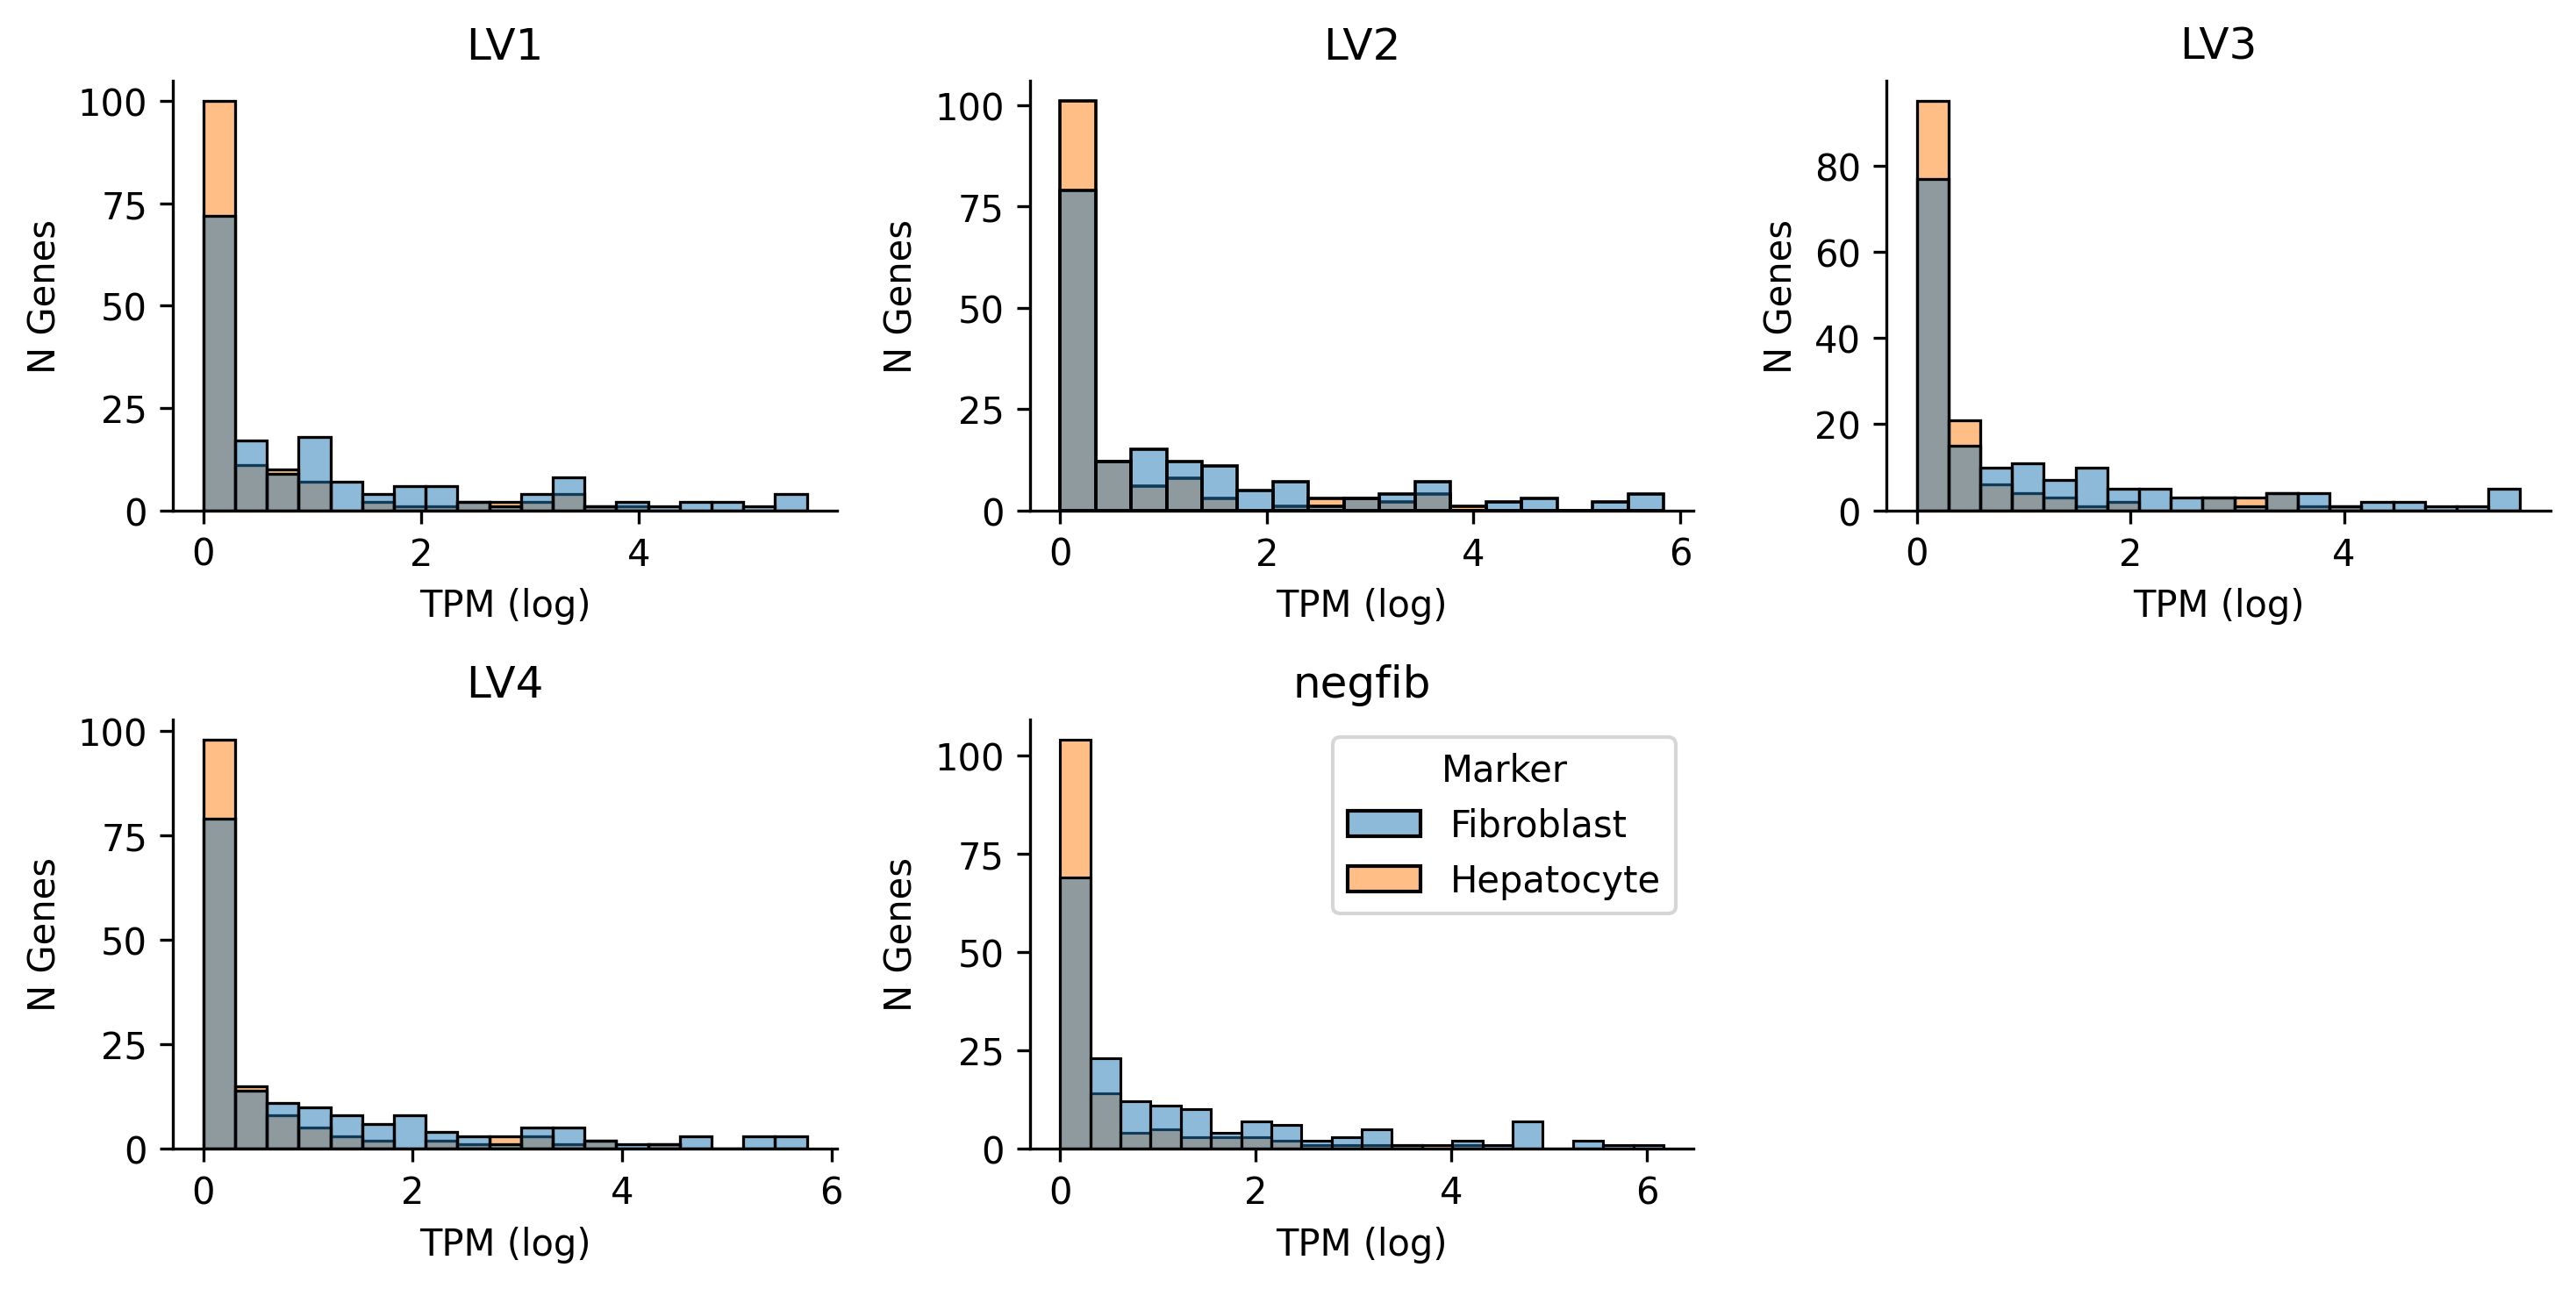

In [29]:
pdf = df.copy()

pdf = pdf[pdf['gene_name'].isin(fb) | pdf['gene_name'].isin(hp)]
print(f"{pdf.shape=}")

pdf['Marker'] = np.where(pdf['gene_name'].isin(fb), 'Fibroblast', 'Hepatocyte')
pdf['is_FB'] = np.where(pdf['gene_name'].isin(fb), True, False)
pdf['is_HP'] = np.where(pdf['gene_name'].isin(hp), True, False)

plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(2, 3)
axs = axs.ravel()

for i, (file, group) in enumerate(pdf.groupby('file')):

    sns.histplot(data=group,
                 # bins=np.ara/nge(0, 10, 1),
                 x='logTPM',
                 hue='Marker',
                 ax=axs[i])

    axs[i].set_ylabel("N Genes")
    axs[i].set_xlabel("TPM (log)")
    axs[i].set_title(file)

    if not i == 4:
        axs[i].legend().remove()


plt.tight_layout()
sns.despine()
fig.delaxes(axs[5])

Thu Nov  9 11:50:24 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Thu Nov  9 11:50:24 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pdf.shape=(1555, 12)


Thu Nov  9 11:50:24 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Thu Nov  9 11:50:24 2023 WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


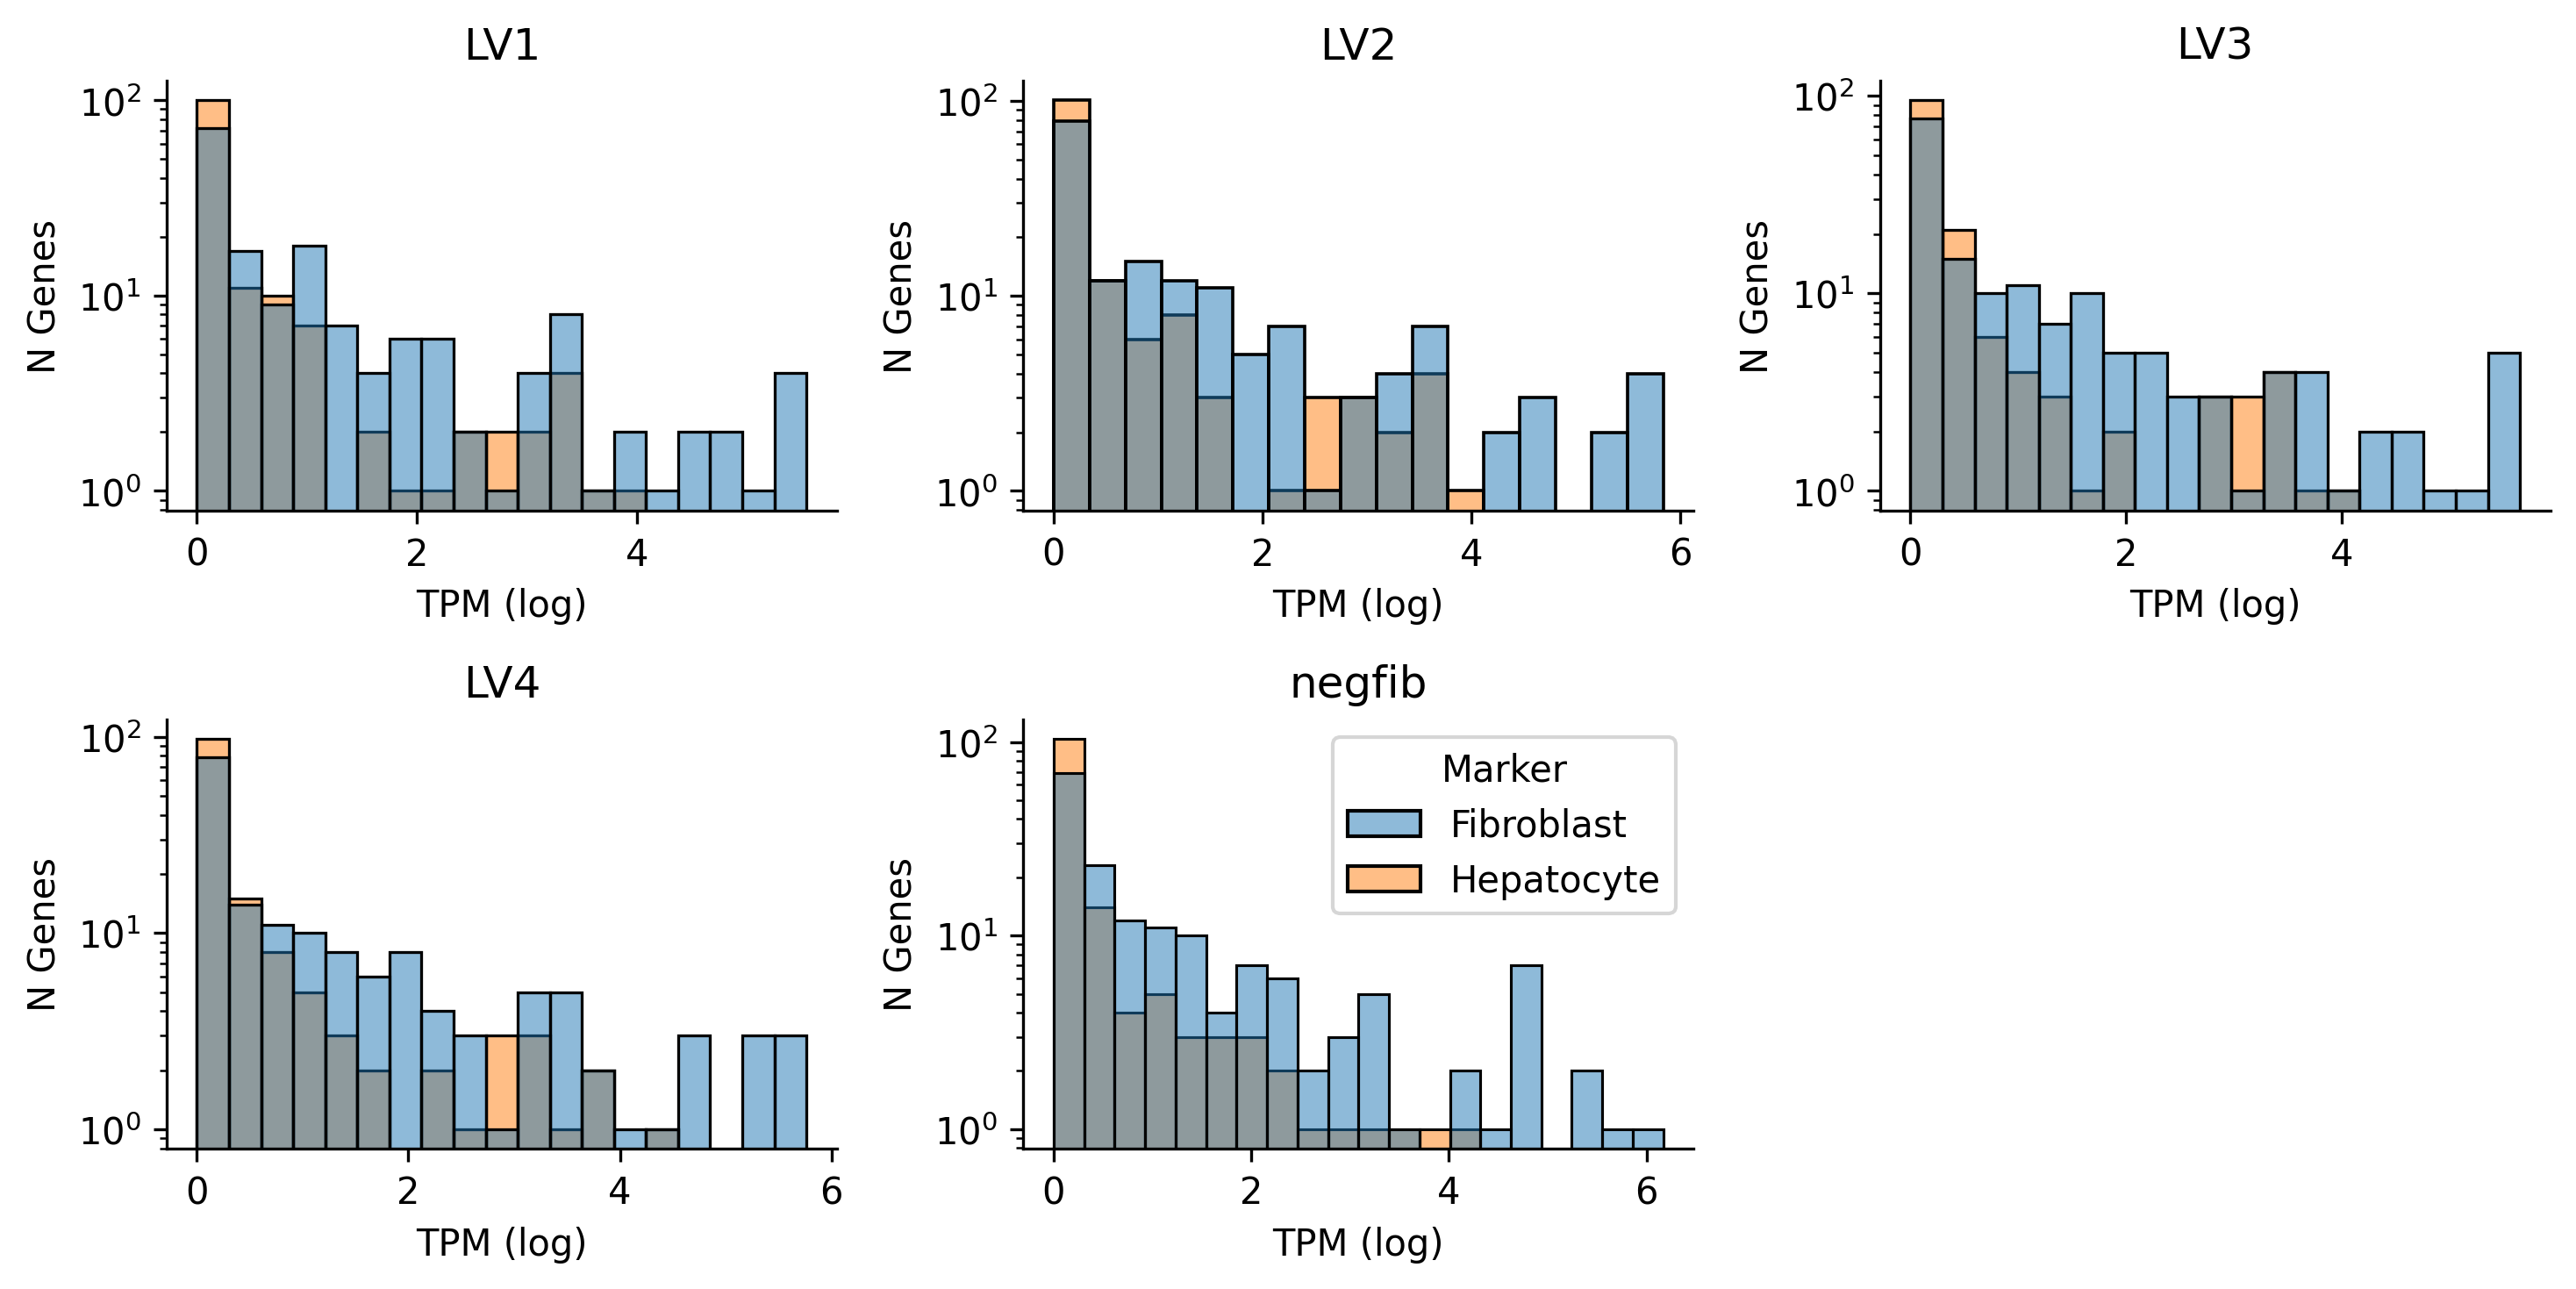

In [30]:
pdf = df.copy()

pdf = pdf[pdf['gene_name'].isin(fb) | pdf['gene_name'].isin(hp)]
print(f"{pdf.shape=}")

pdf['Marker'] = np.where(pdf['gene_name'].isin(fb), 'Fibroblast', 'Hepatocyte')
pdf['is_FB'] = np.where(pdf['gene_name'].isin(fb), True, False)
pdf['is_HP'] = np.where(pdf['gene_name'].isin(hp), True, False)

plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(2, 3)
axs = axs.ravel()

for i, (file, group) in enumerate(pdf.groupby('file')):

    sns.histplot(data=group,
                 # bins=np.ara/nge(0, 10, 1),
                 x='logTPM',
                 hue='Marker',
                 ax=axs[i])

    axs[i].set_ylabel("N Genes")
    axs[i].set_yscale("log")
    axs[i].set_xlabel("TPM (log)")
    axs[i].set_title(file)

    if not i == 4:
        axs[i].legend().remove()


plt.tight_layout()
sns.despine()
fig.delaxes(axs[5])

pdf.shape=(1555, 12)


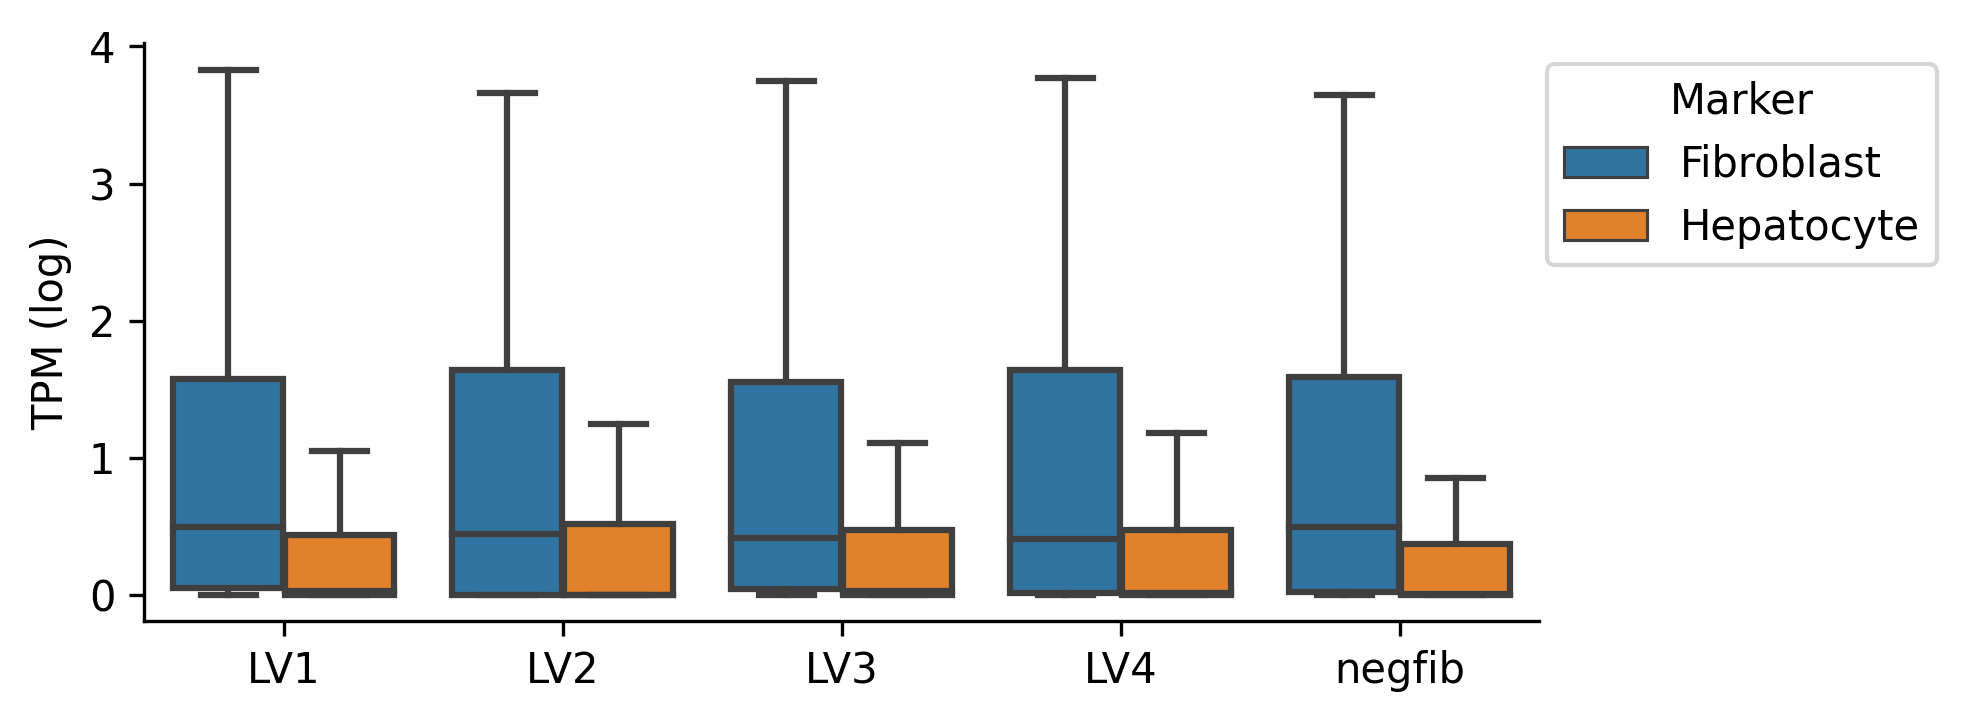

In [31]:
pdf = df.copy()

pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['gene_name'].isin(fb) | pdf['gene_name'].isin(hp)]
print(f"{pdf.shape=}")

pdf['Marker'] = np.where(pdf['gene_name'].isin(fb), 'Fibroblast', 'Hepatocyte')

plt.rcParams['figure.figsize'] = 6, 2.5
plt.rcParams['figure.dpi'] = 300

sns.boxplot(data=pdf,
             x='file',
             y='logTPM',
             hue='Marker',
             showfliers=False)

ax = plt.gca()
ax.set_xlabel("")
ax.set_ylabel("TPM (log)")

sns.move_legend(ax,
                loc='upper right',
                bbox_to_anchor=(1.3, 1))

sns.despine()

pdf.shape=(1023, 12)


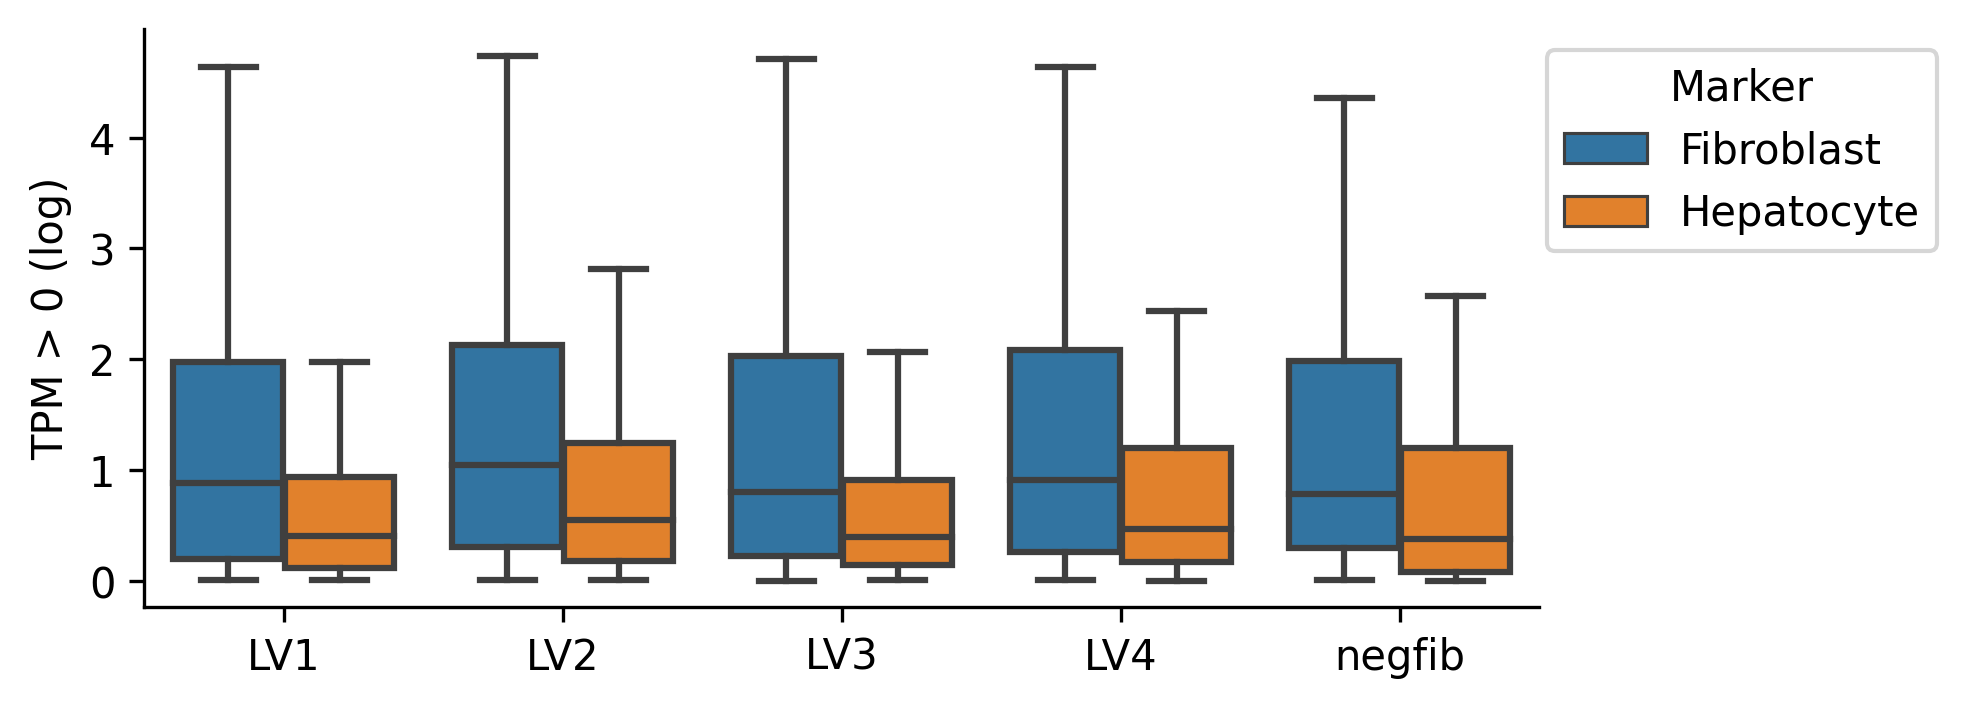

In [32]:
pdf = df.copy()

pdf = pdf.sort_values(by='file')
pdf = pdf[pdf['gene_name'].isin(fb) | pdf['gene_name'].isin(hp)]
pdf = pdf[pdf['logTPM'] > 0]
print(f"{pdf.shape=}")

pdf['Marker'] = np.where(pdf['gene_name'].isin(fb), 'Fibroblast', 'Hepatocyte')

plt.rcParams['figure.figsize'] = 6, 2.5
plt.rcParams['figure.dpi'] = 300

sns.boxplot(data=pdf,
             x='file',
             y='logTPM',
             hue='Marker',
             showfliers=False)

ax = plt.gca()
ax.set_xlabel("")
ax.set_ylabel("TPM > 0 (log)")

sns.move_legend(ax,
                loc='upper right',
                bbox_to_anchor=(1.3, 1))

sns.despine()

# explore nanocount outputs

In [33]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/ihep/talon/talon_summarize_talon_summary.tsv"

df = pd.read_csv(fpath, '\t')
df = df.sort_values(by='dataset')
df['file'] = df['dataset'].apply(lambda x: x.split("_")[1])
df.head()


/home/cstansbu/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,dataset,reads_annotated,known_genes,antisense_genes,other_novel_genes,known_transcripts,novel_transcripts,ISMs,prefix_ISMs,suffix_ISMs,NICs,NNCs,antisense_transcripts,genomic_transcripts,file
4,ihep_LV1,13972,2410,1658,76,510,3819,165,0,0,0,0,1658,1920,LV1
0,ihep_LV2,4968,1190,781,23,317,1717,85,0,0,0,0,781,828,LV2
3,ihep_LV3,17256,2501,1661,58,577,3824,179,0,0,0,0,1661,1926,LV3
2,ihep_LV4,14605,2263,1521,65,503,3498,159,0,0,0,0,1521,1753,LV4
1,ihep_negfib,20935,2798,1926,81,640,4403,209,0,0,0,0,1926,2187,negfib


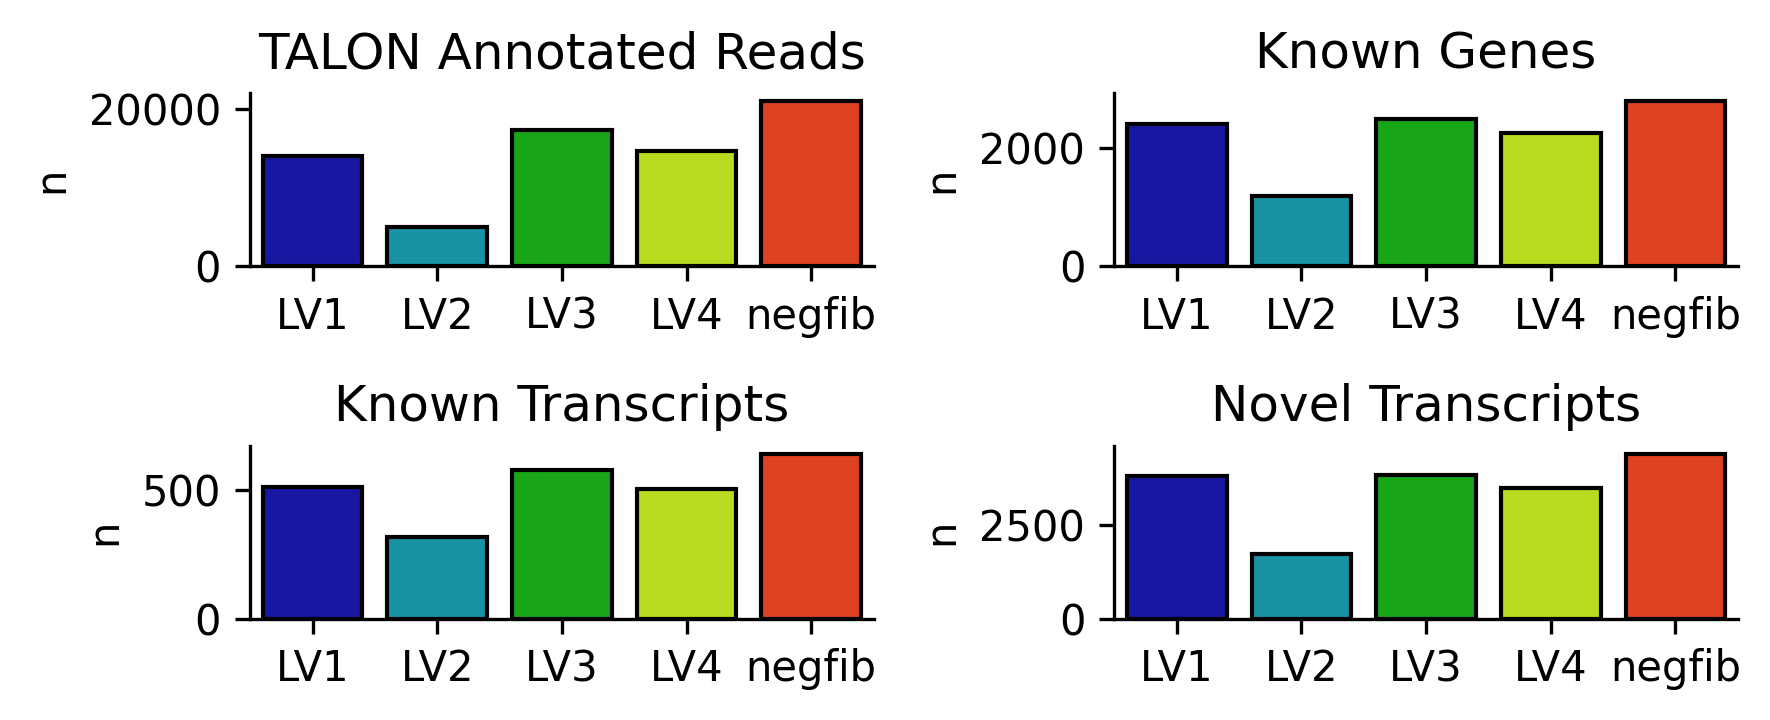

In [34]:
pdf = df.copy()

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

plt.rcParams['figure.figsize'] = 5.5, 3.5
plt.rcParams['figure.dpi'] = 300

sns.barplot(data=pdf,
            x='file',
            y='reads_annotated',
            palette='nipy_spectral', 
            ax=axs[0],
            ec='k')


axs[0].set_title('TALON Annotated Reads')
axs[0].set_ylabel('n')
axs[0].set_xlabel("")

sns.barplot(data=pdf,
            x='file',
            y='known_genes',
            palette='nipy_spectral', 
            ax=axs[1],
            ec='k')

axs[1].set_title('Known Genes')
axs[1].set_ylabel('n')
axs[1].set_xlabel("")

sns.barplot(data=pdf,
            x='file',
            y='known_transcripts',
            palette='nipy_spectral', 
            ax=axs[2],
            ec='k')

axs[2].set_title('Known Transcripts')
axs[2].set_ylabel('n')
axs[2].set_xlabel("")


sns.barplot(data=pdf,
            x='file',
            y='novel_transcripts',
            palette='nipy_spectral', 
            ax=axs[3],
            ec='k')


axs[3].set_title('Novel Transcripts')
axs[3].set_ylabel('n')
axs[3].set_xlabel("")

plt.tight_layout()
sns.despine()


In [35]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/ihep/talon/talon_abundance_talon_abundance.tsv"

df = pd.read_csv(fpath, '\t')
print(f"{df.shape=}")

df.head()

df.shape=(11458, 16)


/home/cstansbu/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,gene_ID,transcript_ID,annot_gene_id,annot_transcript_id,annot_gene_name,annot_transcript_name,n_exons,length,gene_novelty,transcript_novelty,ISM_subtype,ihep_LV2,ihep_negfib,ihep_LV4,ihep_LV3,ihep_LV1
0,91,352,ENSG00000288398,ENST00000671994,TALONG000000091,TALONT000000352,1,2662,Known,Known,None,0,1,0,0,0
1,105,382,ENSG00000226396,ENST00000457263,TALONG000000105,TALONT000000382,1,455,Known,Known,None,0,1,0,0,1
2,214,752,ENSG00000228589,ENST00000436160,SPCS2P4,SPCS2P4-201,1,681,Known,Known,None,2,6,5,3,2
3,224,768,ENSG00000215895,ENST00000442006,HSPA5P1,HSPA5P1-201,1,1960,Known,Known,None,0,5,1,2,1
4,267,892,ENSG00000224751,ENST00000419974,SHMT1P1,SHMT1P1-201,1,1312,Known,Known,None,1,0,0,0,1


In [36]:
pdf = df.copy()
p = 1000
scale_by = 1e6

pdf = pdf[pdf['gene_novelty'] == 'Known']
pdf = pdf[pdf['transcript_novelty'] == 'Known']

control_cols = [
    'ihep_LV1',
    'ihep_LV2',
    'ihep_LV3',
    'ihep_LV4',   
]

pdf['TF'] = pdf[control_cols].sum(axis=1)
pdf['control'] = pdf['ihep_negfib'].copy()


# normalize expression
pdf['control_rpg'] = pdf['control'] / (pdf['length'] / p)
pdf['control_TPM'] = scale_by * (pdf['control_rpg'] / pdf['control'].sum())

pdf['TF_rpg'] = pdf['TF'] / (pdf['length'] / p)
pdf['TF_TPM'] = scale_by * (pdf['TF_rpg'] / pdf['TF'].sum())


## simplify the transcript table by dropping columns
cols = [
    'annot_gene_name', 
    'annot_transcript_name',
    'n_exons',
    'control',
    'TF',
    'control_TPM',
    'TF_TPM'
    
]
pdf = pdf[cols]

# build gene-level expression
pdf['control_gx'] = pdf.groupby('annot_gene_name')['control_TPM'].transform('sum')
pdf['TF_gx'] = pdf.groupby('annot_gene_name')['TF_TPM'].transform('sum')

# compute transcript fold change and gene fols change
pdf['foldchange_gx'] = np.log2((pdf['TF_gx'] + 1) / (pdf['control_gx'] + 1))
pdf['foldchange_tx'] = np.log2((pdf['TF_TPM'] + 1) / (pdf['control_TPM'] + 1))


pdf.head()

,annot_gene_name,annot_transcript_name,n_exons,control,TF,control_TPM,TF_TPM,control_gx,TF_gx,foldchange_gx,foldchange_tx
0,TALONG000000091,TALONT000000352,1,1,0,52.827647,0.000000,52.827647,0.000000,-5.750275,-5.750275
1,TALONG000000105,TALONT000000382,1,1,1,309.070763,130.209266,309.070763,130.209266,-1.240728,-1.240728
2,SPCS2P4,SPCS2P4-201,1,6,12,1239.006144,1043.968563,1239.006144,1043.968563,-0.246888,-0.246888
3,HSPA5P1,HSPA5P1-201,1,5,4,358.742850,120.908604,358.742850,120.908604,-1.561166,-1.561166
4,SHMT1P1,SHMT1P1-201,1,0,2,0.000000,90.312829,0.000000,90.312829,6.512746,6.512746


In [38]:
# extract all transcripts with evidence of differential splicing

dx = pdf[pdf['foldchange_gx'] != pdf['foldchange_tx']].reset_index(drop=True)
print(f"{dx.shape=}")
dx


dx.shape=(9, 11)


,annot_gene_name,annot_transcript_name,n_exons,control,TF,control_TPM,TF_TPM,control_gx,TF_gx,foldchange_gx,foldchange_tx
0,Y_RNA,Y_RNA.113-201,1,1,0,1496.034014,0.000000,2902.305987,598.436525,-2.276018,-10.547891
1,Y_RNA,Y_RNA.110-201,1,0,1,0.000000,598.436525,2902.305987,598.436525,-2.276018,9.227463
2,Y_RNA,Y_RNA.561-201,1,1,0,1406.271973,0.000000,2902.305987,598.436525,-2.276018,-10.458685
3,RPL6P27,RPL6P27-201,1,1,2,162.199766,136.667165,5891.455952,6719.468937,0.189693,-0.245454
4,RPL6P27,RPL6P27-203,1,11,30,5729.256186,6582.801772,5891.455952,6719.468937,0.189693,0.200321
5,ZNF677,ZNF677-209,1,0,1,0.000000,18.473719,0.000000,51.369452,5.710654,4.283457
6,ZNF677,ZNF677-202,1,0,1,0.000000,32.895733,0.000000,51.369452,5.710654,5.083032
7,ZNF224,ZNF224-203,1,0,1,0.000000,38.173464,0.000000,57.961445,5.881700,5.291805
8,ZNF224,ZNF224-207,1,0,1,0.000000,19.787981,0.000000,57.961445,5.881700,4.377678


In [53]:
cols = [
    'annot_gene_name', 
    'annot_transcript_name',
    'control', 
    'TF',
    'control_TPM',
    'TF_TPM', 
    'foldchange_gx',
    'foldchange_tx'
]

ddf = dx[cols]
ddf.columns = ['Gene ',
               'Isoform', 
               'Reads (C)',
               'Reads (TF)',
               'TPM (C)', 
               'TPM (TF)',
               'Fold Change (Gene)',
               'Fold Change (Isoform)']

print(tabulate(ddf,  
               headers=ddf.columns, 
               tablefmt='plain', 
               showindex=False))


Gene     Isoform          Reads (C)    Reads (TF)    TPM (C)    TPM (TF)    Fold Change (Gene)    Fold Change (Isoform)
-------  -------------  -----------  ------------  ---------  ----------  --------------------  -----------------------
Y_RNA    Y_RNA.113-201            1             0    1496.03      0                  -2.27602                -10.5479
Y_RNA    Y_RNA.110-201            0             1       0       598.437              -2.27602                  9.22746
Y_RNA    Y_RNA.561-201            1             0    1406.27      0                  -2.27602                -10.4587
RPL6P27  RPL6P27-201              1             2     162.2     136.667               0.189693                -0.245454
RPL6P27  RPL6P27-203             11            30    5729.26   6582.8                 0.189693                 0.200321
ZNF677   ZNF677-209               0             1       0        18.4737              5.71065                  4.28346
ZNF677   ZNF677-202               0           

In [50]:
?tabulate

Signature:
tabulate(
    tabular_data,
    headers=(),
    tablefmt='simple',
    floatfmt='g',
    intfmt='',
    numalign='default',
    stralign='default',
    missingval='',
    showindex='default',
    disable_numparse=False,
    colalign=None,
    maxcolwidths=None,
    rowalign=None,
    maxheadercolwidths=None,
)
Docstring:
Format a fixed width table for pretty printing.

>>> print(tabulate([[1, 2.34], [-56, "8.999"], ["2", "10001"]]))
---  ---------
  1      2.34
-56      8.999
  2  10001
---  ---------

The first required argument (`tabular_data`) can be a
list-of-lists (or another iterable of iterables), a list of named
tuples, a dictionary of iterables, an iterable of dictionaries,
an iterable of dataclasses (Python 3.7+), a two-dimensional NumPy array,
NumPy record array, or a Pandas' dataframe.


Table headers
-------------

To print nice column headers, supply the second argument (`headers`):

  - `headers` can be an explicit list of column headers
  - if `headers="first